In [1]:
# Importing necessary libraries
from utils import *

In [2]:
# Hyperparameters and paths

first_execution = True  # Set to True for the first execution to split the excel file

RAW = Path("data/raw/Observations_2012-2025.xlsx")
OUT_FILT = Path("data/filtered")
OUT_CLEAN = Path("data/cleaned")
OUT_DRAFT = Path("data/drafts")
OUT_FIG = Path("figures/")

sheets_to_csv_filtered = {
    "ESPECES": "especes.csv",
    "GPS-MILIEU": "gps_milieu.csv",
    "NOM FRANÇAIS": "observations.csv",
}

sheets_to_csv_cleaned = {
    "ESPECES": "especes_clean.csv",
    "GPS-MILIEU": "gps_milieu_clean.csv",
    "NOM FRANÇAIS": "nom_francais_clean.csv",
}


In [3]:
# Original sheets declaration : 

# Run on the first execution to split and save the excel file into multiple csv files
if first_execution:
    print(split_excel_to_csvs(RAW, OUT_FILT, sheets_to_csv_filtered))

# For following executions, load the csv files directly
dfs = load_csvs(OUT_FILT, sheets_to_csv_filtered)
for k, df in dfs.items():
    print(f"{k}: {df.shape}")


# Visual inspection of dataframes, uncoment as needed
# dfs['ESPECES'].head()
# dfs['GPS-MILIEU'].head()
# dfs['NOM FRANÇAIS'].head()

{'ESPECES': 'data/filtered/especes.csv', 'GPS-MILIEU': 'data/filtered/gps_milieu.csv', 'NOM FRANÇAIS': 'data/filtered/observations.csv'}
ESPECES: (86, 5)
GPS-MILIEU: (651, 8)
NOM FRANÇAIS: (114497, 26)


In [4]:
# Cleaned dataframes declaration 

if first_execution:
    # Cleaning dataframes from initial loading issues
    df_clean_especes = clean_especes(dfs["ESPECES"])
    df_clean_gps = clean_gps(dfs["GPS-MILIEU"])
    df_clean_nom_francais = clean_observations(dfs["NOM FRANÇAIS"])

    # Saving cleaned dataframes back to csv files
    save_clean_csvs({"ESPECES": df_clean_especes, "GPS-MILIEU": df_clean_gps, "NOM FRANÇAIS": df_clean_nom_francais}, OUT_CLEAN)

else:
    # Loading cleaned dataframes directly from csv files
    clean_dfs = load_csvs(OUT_CLEAN, sheets_to_csv_cleaned)
    df_clean_especes = clean_dfs["ESPECES"]
    df_clean_gps = clean_dfs["GPS-MILIEU"]
    df_clean_nom_francais = clean_dfs["NOM FRANÇAIS"]

# uncomment as needed to inspect cleaned dataframes
# df_clean_especes.head()
# df_clean_gps.head()
# df_clean_nom_francais.head()

## Dataset Familiarisation and Descriptive Analysis 
---

In [5]:
print("Data orientation summaries : ")
print(f"- Especes : {df_clean_especes.shape}")
print(f"- GPS : {df_clean_gps.shape}")
print(f"- Nom Français : {df_clean_nom_francais.shape}")

Data orientation summaries : 
- Especes : (87, 3)
- GPS : (650, 6)
- Nom Français : (114495, 26)



## Especes : 

In [6]:
df = df_clean_especes.copy()

# Basic structure and uniqueness check 
print("Number of species:", len(df))
print("Unique ESPECIES_NAME:", df["ESPECIES_NAME"].nunique())
print("Unique LATIN_NAME:", df["LATIN_NAME"].nunique())

# Check for duplicates
dup_species = df[df["ESPECIES_NAME"].duplicated(keep=False)].sort_values("ESPECIES_NAME")
dup_latin   = df[df["LATIN_NAME"].duplicated(keep=False)].sort_values("LATIN_NAME")

print("Duplicated:")
display(dup_species)


Number of species: 87
Unique ESPECIES_NAME: 86
Unique LATIN_NAME: 86
Duplicated:


ESPECIES_NAME        LATIN_NAME                         NATURE
7  Astrild ondulé  Estrilda astrild  Exogène introduit par l'homme
8  Astrild ondulé  Estrilda astrild  Exogène introduit par l'homme

In [7]:
# "Families" aer defined by a shared root 
df["ESPECIES_FAMILY"] = df["ESPECIES_NAME"].str.split().str[0]
df["LATIN_FAMILY"] = df["LATIN_NAME"].str.split().str[0]

# Count distinct families
especies_families = df["ESPECIES_FAMILY"].value_counts().reset_index()
especies_families.columns = ["ESPECIES_FAMILY", "N_ESPECIES"]

latin_families = df["LATIN_FAMILY"].value_counts().reset_index()
latin_families.columns = ["LATIN_FAMILY", "N_ESPECIES"]
    
# Also build Python dictionaries
species_family_dict = dict(zip(especies_families["ESPECIES_FAMILY"], especies_families["N_ESPECIES"]))
latin_family_dict = dict(zip(latin_families["LATIN_FAMILY"], latin_families["N_ESPECIES"]))

print("French name families (count):", len(species_family_dict))
print("Latin name families (count):", len(latin_family_dict))

print("Top 10 families (by French names):")
display(especies_families.head(10))
print("Top 10 families (by Latin names):")
display(latin_families.head(10))


French name families (count): 53
Latin name families (count): 71
Top 10 families (by French names):


ESPECIES_FAMILY  N_ESPECIES
0        Aigrette           4
1         Astrild           4
2         Colibri           4
3       Chevalier           4
4         Moqueur           4
5          Sterne           4
6      Sporophile           3
7      Hirondelle           3
8     Tourterelle           3
9         Colombe           3

Top 10 families (by Latin names):


LATIN_FAMILY  N_ESPECIES
0      Egretta           4
1     Estrilda           4
2       Tringa           3
3        Falco           3
4     Eulampis           2
5     Lonchura           2
6    Geotrygon           2
7  Onychoprion           2
8        Ardea           2
9      Zenaida           2

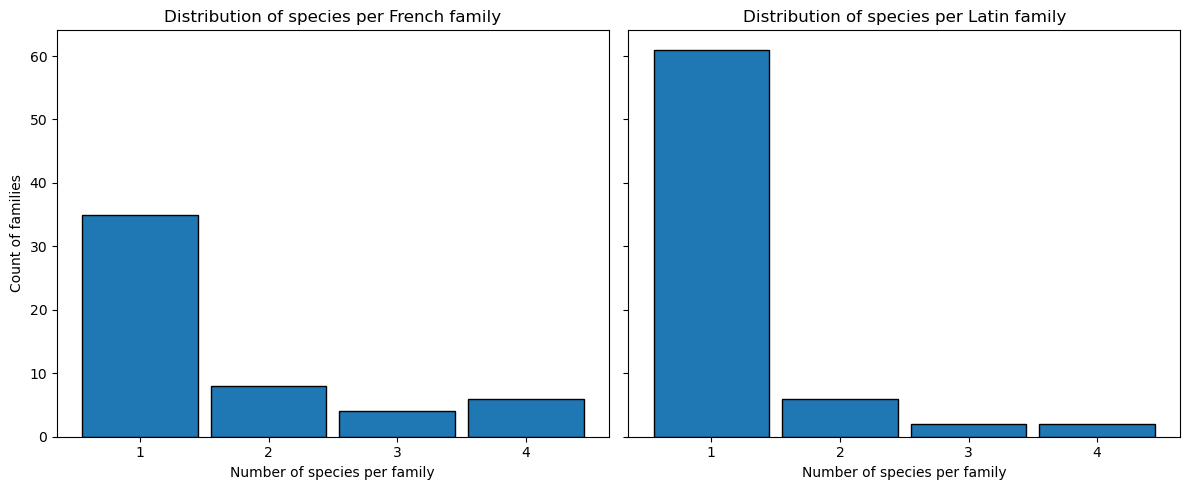

In [8]:
# Plot distribution of family sizes 
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

max_fr = int(especies_families["N_ESPECIES"].max())
bins_fr = np.arange(0.5, max_fr + 1.5, 1)
axes[0].hist(especies_families["N_ESPECIES"], bins=bins_fr, edgecolor='black', rwidth=0.9)
axes[0].set_title("Distribution of species per French family")
axes[0].set_xlabel("Number of species per family")
axes[0].set_ylabel("Count of families")
axes[0].set_xticks(np.arange(1, max_fr + 1, 1))

max_la = int(latin_families["N_ESPECIES"].max())
bins_la = np.arange(0.5, max_la + 1.5, 1)
axes[1].hist(latin_families["N_ESPECIES"], bins=bins_la, edgecolor='black', rwidth=0.9)
axes[1].set_title("Distribution of species per Latin family")
axes[1].set_xlabel("Number of species per family")
axes[1].set_xticks(np.arange(1, max_la + 1, 1))

plt.tight_layout()
plt.show()



Distinct NATURE values:
NATURE
Migrateur                         24
Autochtone                        19
Exogène introduit par l'homme     15
Endémique des Petites Antilles    13
Marin                              8
Exogène colonisateur naturel       4
Endémique de la Martinique         2
                                   1
Migrateur rare                     1
Name: count, dtype: int64
Nature distribution per family:


ESPECIES_FAMILY                         NATURE  count
0        Aigrette                      Migrateur      4
1         Amazone  Exogène introduit par l'homme      1
3         Astrild  Exogène introduit par l'homme      3
2         Astrild                                     1
4       Balbuzard                      Migrateur      1
5         Bengali  Exogène introduit par l'homme      1
6        Bihoreau                     Autochtone      1
7        Bihoreau                      Migrateur      1
8       Bécasseau                      Migrateur      1
9          Canard  Exogène introduit par l'homme      1

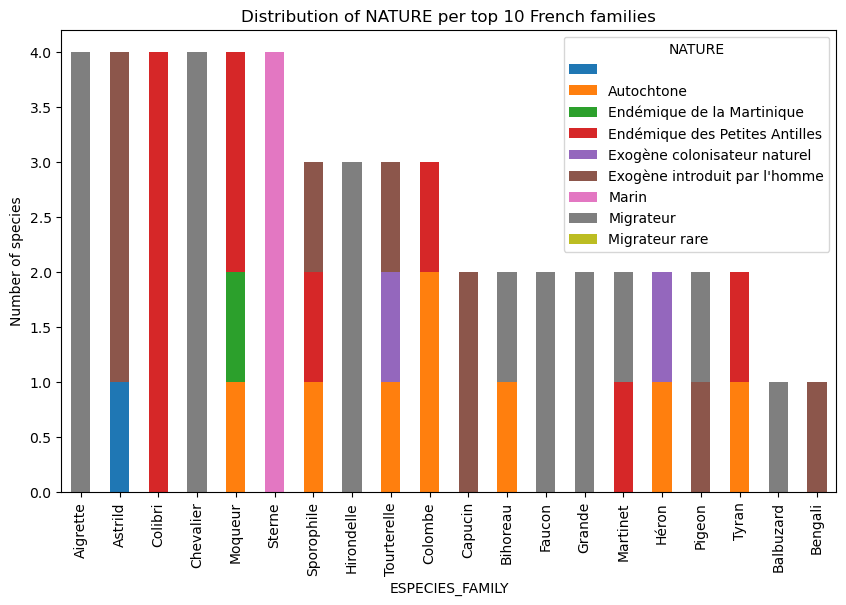

In [9]:
# NATURE analysis 
print("Distinct NATURE values:")
print(df["NATURE"].value_counts())

# Distribution of NATURE per family 
nature_by_family = (
    df.groupby(["ESPECIES_FAMILY", "NATURE"])
      .size()
      .reset_index(name="count")
)

print("Nature distribution per family:")
display(nature_by_family.sort_values(["ESPECIES_FAMILY", "count"], ascending=[True, False]).head(10))

# Pivot to make a clearer table
nature_pivot = nature_by_family.pivot_table(
    index="ESPECIES_FAMILY", columns="NATURE", values="count", fill_value=0
).astype(int)

# Plot top 10 families by total species
top_fams = nature_pivot.sum(axis=1).sort_values(ascending=False).head(20).index
nature_pivot.loc[top_fams].plot(
    kind="bar", stacked=True, figsize=(10, 6),
    title="Distribution of NATURE per top 10 French families"
)
plt.ylabel("Number of species")
if first_execution:
    plt.savefig(OUT_FIG / "nature_distribution_top_families.png")
plt.show()


## GPS-MILIEU :

In [10]:
df = df_clean_gps.copy()

# Count distinct habitat types 
n_habitats = df["HABITAT_TYPE"].nunique()
print(f"Number of distinct habitat types: {n_habitats}")
print("Habitat types frequency:")
print(df["HABITAT_TYPE"].value_counts())

# Link habitat types to unique transect names 
# Remove duplicates so that each (habitat, transect_name) pair appears only once
habitat_transect = (
    df[["HABITAT_TYPE", "TRANSECT_NAME"]]
    .drop_duplicates()
    .sort_values(["HABITAT_TYPE", "TRANSECT_NAME"])
)

# For each habitat type, list unique transects
habitat_to_transects = (
    habitat_transect.groupby("HABITAT_TYPE")["TRANSECT_NAME"]
    .apply(list)
    .to_dict()
)

# Display summary 
print("Habitat type → number of unique transects:")
for habitat, transects in habitat_to_transects.items():
    print(f"- {habitat}: {len(transects)} transects")


Number of distinct habitat types: 7
Habitat types frequency:
HABITAT_TYPE
Forêt sèche     186
Agricole        134
Forêt humide    130
Périurbain      120
Mangrove         30
Plage            30
Urbain           20
Name: count, dtype: int64
Habitat type → number of unique transects:
- Agricole: 14 transects
- Forêt humide: 13 transects
- Forêt sèche: 19 transects
- Mangrove: 3 transects
- Plage: 3 transects
- Périurbain: 12 transects
- Urbain: 2 transects


In [11]:
# Examples
for habitat, transects in list(habitat_to_transects.items()):
    print(f"\n{habitat} ({len(transects)} transects):")
    print(transects)

# make a summary DataFrame and plot 
habitat_summary = (
    pd.DataFrame({
        "HABITAT_TYPE": list(habitat_to_transects.keys()),
        "N_TRANSECTS": [len(v) for v in habitat_to_transects.values()]
    })
    .sort_values("N_TRANSECTS", ascending=False)
)


Agricole (14 transects):
['Bois Pothau', 'Canal Cocotte', 'Cap Est', 'Carrère', 'Fonds Préville', 'Galion', 'Galion 2', 'Génipa', 'Habitation Petite Rivière', 'Hôtel des Plaisirs', 'Lafayette', 'Morne Babet', 'Moulin à Vent', 'Verrier']

Forêt humide (13 transects):
['Anse Couleuvre', 'Bois La Charles', 'Bouliki', "Domaine d'Emeraude", 'Fond Baron', "Fond l'Etang", 'Forêt Montravail', 'Forêt la Reculée', 'La Démarche 2', "Rivière l'Or", 'Route Forestière de Palourde', 'Tunnel Didier', 'Tunnel Didier 2']

Forêt sèche (19 transects):
['Anse Mathurin', 'Blin', 'Bois Pothau', 'Forêt Vatable', 'Forêt Vatable 2', 'Forêt la Philippe', 'Ilets du François', 'Ilets du Robert', 'Le Phare-Caravelle', 'Morne Bellevue', 'Morne Gardier', 'Petit Sentier RNC', 'Piton Crève-cœur', 'Pointe Banane', 'Pointe Jean-Claude', 'Pointe La Rose', 'Pointe Lynch', 'Pointe Rouge', 'Rocher Leclerc']

Mangrove (3 transects):
['Aéroport', 'Boucle du Vauclin', 'Morne Cabri']

Plage (3 transects):
['Anse Meunier', 'Autr

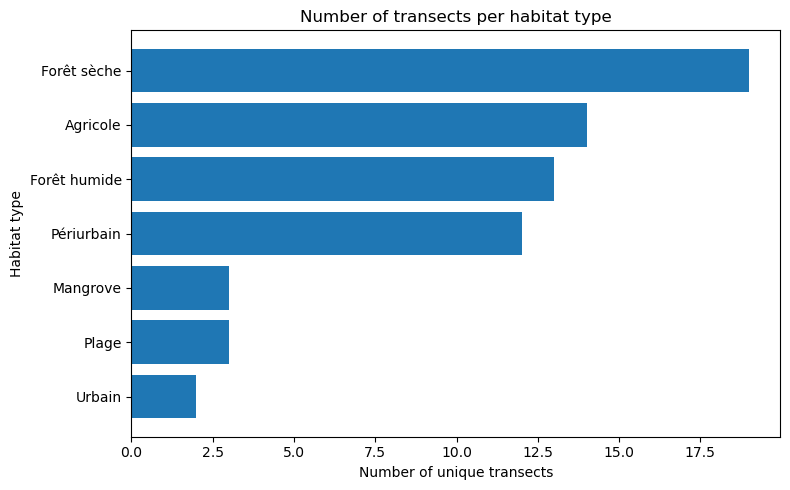

In [12]:
# Bar plot: how many transects per habitat type

plt.figure(figsize=(8, 5))
plt.barh(habitat_summary["HABITAT_TYPE"], habitat_summary["N_TRANSECTS"])
plt.xlabel("Number of unique transects")
plt.ylabel("Habitat type")
plt.title("Number of transects per habitat type")
plt.gca().invert_yaxis()
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "transects_per_habitat.png")
plt.show()

## Nom_Français : 

year  N_observations  N_species  Total_birds  Mean_birds_per_obs
0   2014.0            5378         64        10713            1.992004
1   2015.0            8162         70        17319            2.121906
2   2016.0           11011         78        22888            2.078649
3   2017.0            9228         71        20519            2.223559
4   2018.0            9733         73        20325            2.088256
5   2019.0            9572         70        21005            2.194421
6   2020.0            9956         68        21986            2.208317
7   2021.0           10604         69        23914            2.255187
8   2022.0           10804         68        24416            2.259904
9   2023.0           10224         67        22269            2.178110
10  2024.0           10051         70        21591            2.148144
11  2025.0            9266         72        19884            2.145910

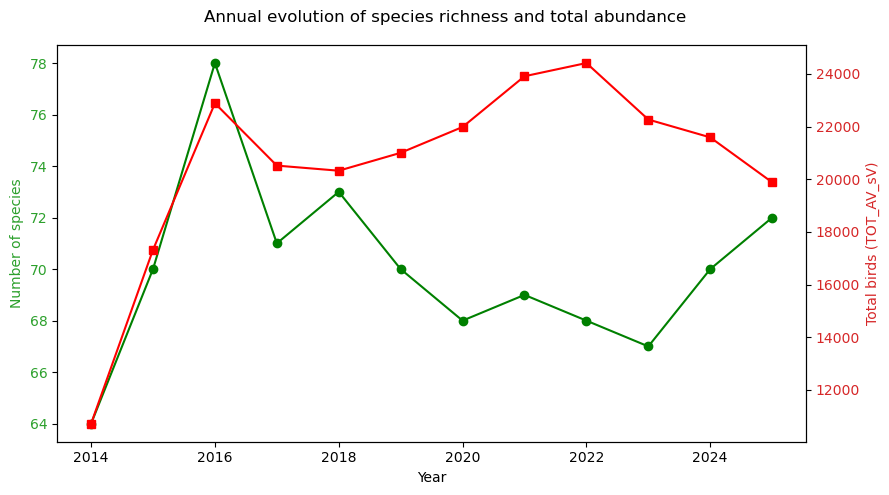

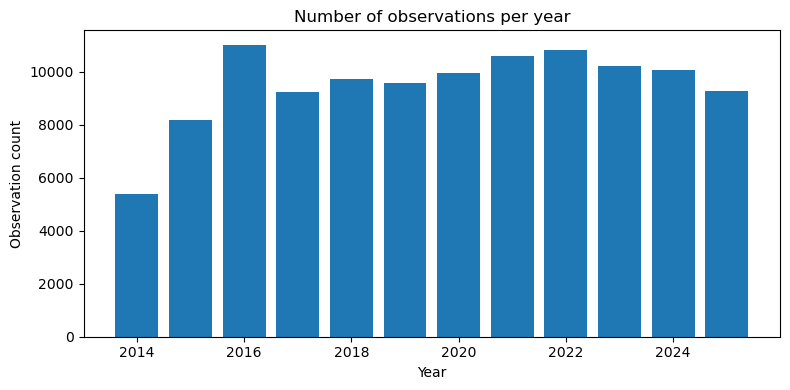

In [13]:
# Assume the cleaned observations table is already loaded:

df = df_clean_nom_francais.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# Basic yearly counts 
annual_summary = (df.groupby("year").agg(
          N_observations=("ESPECE", "size"),
          N_species=("ESPECE", "nunique"),
          Total_birds=("TOT_AV_sV", "sum"),
          Mean_birds_per_obs=("TOT_AV_sV", "mean")
        ).reset_index()
)

display(annual_summary)

# Plot species richness and total abundance per year 
fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.plot(annual_summary["year"], annual_summary["N_species"], marker="o", color="green", label="Species richness")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of species", color="tab:green")
ax1.tick_params(axis="y", labelcolor="tab:green")

ax2 = ax1.twinx()
ax2.plot(annual_summary["year"], annual_summary["Total_birds"], marker="s", color="red", label="Total birds")
ax2.set_ylabel("Total birds (TOT_AV_sV)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.suptitle("Annual evolution of species richness and total abundance")
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "annual_species_richness_abundance.png")
plt.show()

# Histogram: number of observations per year 
plt.figure(figsize=(8,4))
plt.bar(annual_summary["year"], annual_summary["N_observations"], color="tab:blue")
plt.title("Number of observations per year")
plt.xlabel("Year")
plt.ylabel("Observation count")
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "observations_per_year.png")
plt.show()


Nom observateur  N_observations  N_years  N_species_seen  \
19               CONDE Beatriz           41435       12              79   
6              BAHUAUD Anthony            8719       10              65   
10                BELFAN David            7331       12              48   
36                 MAUGEE Lévy            6838       12              47   
5          AUGUSTE  Christophe            5054       12              40   
35  MARRAUD des GROTTES Roland            4229       12              40   
3           ALEXANDRINE Thomas            3154       12              30   
40                 PICARD Rémi            3116        4              44   
38          MOURIESSE Jocelyne            3093       12              47   
47               VALSIN Michel            2284        9              40   

    Mean_birds  Total_birds  
19    2.166043        89750  
6     2.091868        18239  
10    2.920748        21412  
36    2.032758        13900  
5     1.628017         8228  
35    1.477418         6248  
3     1.677869         5292  
40    2.486842         7749  
38    2.316844         7166  
47    2.551226         5827

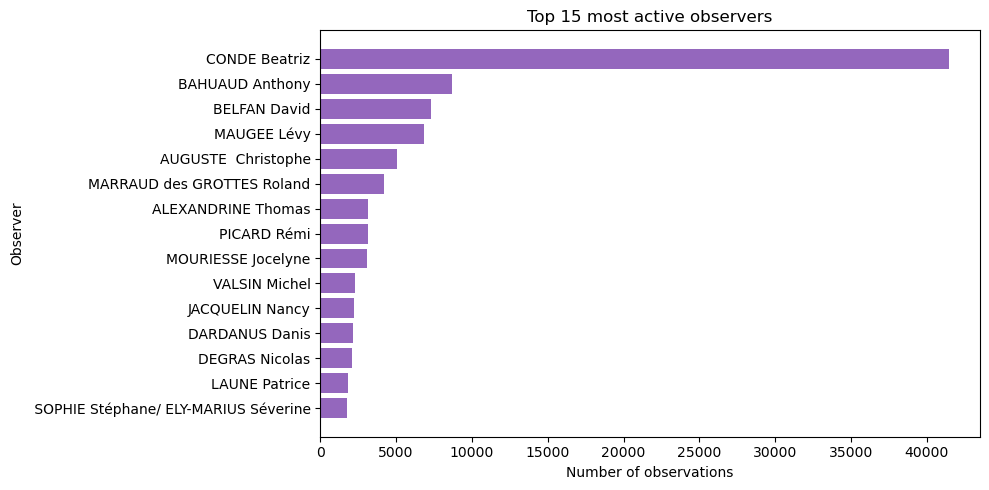

Nom observateur  Mean_count    Variance  \
2   AGAT Arnaud-FREMACX Vincent- NOSEL Christopher    5.588235  772.367059   
11                               BELLUMEUR Wilfrid    3.115187  106.896575   
43                                  ROLLIN Michaël    3.028249   53.908548   
10                                    BELFAN David    2.920748   21.326187   
28                                  FLERIAG Lyneda    2.817460   20.952066   
32                                  LABONNE Annick    3.223656   20.467112   
38                              MOURIESSE Jocelyne    2.316844   15.629202   
31                                 JACQUELIN Nancy    2.924242   11.098137   
18                              CHANTEUR Bénédicte    2.267857    7.934074   
20                                  CONDE Beatriz     2.327536    7.215083   

    count  
2      51  
11   1554  
43    354  
10   7331  
28    756  
32    465  
38   3093  
31   2244  
18    504  
20    345

In [14]:
# Observer participation summary 
observer_summary = (
    df.groupby("Nom observateur")
      .agg(
          N_observations=("ESPECE", "size"),
          N_years=("year", "nunique"),
          N_species_seen=("ESPECE", "nunique"),
          Mean_birds=("TOT_AV_sV", "mean"),
          Total_birds=("TOT_AV_sV", "sum")
      )
      .reset_index()
      .sort_values("N_observations", ascending=False)
)

display(observer_summary.head(10))

# Plot: top observers by number of observations 
plt.figure(figsize=(10,5))
top_obs = observer_summary.head(15)
plt.barh(top_obs["Nom observateur"], top_obs["N_observations"], color="tab:purple")
plt.xlabel("Number of observations")
plt.ylabel("Observer")
plt.title("Top 15 most active observers")
plt.gca().invert_yaxis()
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "top_observers.png")
plt.show()

# Observer consistency: mean vs variance of counts
observer_variability = (
    df.groupby("Nom observateur")["TOT_AV_sV"]
      .agg(["mean", "var", "count"])
      .rename(columns={"mean": "Mean_count", "var": "Variance"})
      .reset_index()
)

# Observers with very high variance relative to mean may indicate inconsistent detection
display(observer_variability.sort_values("Variance", ascending=False).head(10))


In [15]:
# Unique mapping of observer - transect (ignoring point duplicates)
observer_transect = (
    df[["Nom observateur", "Nom transect"]]
    .drop_duplicates()
    .sort_values(["Nom observateur", "Nom transect"])
)

print(f"Total unique observer-transect pairs: {len(observer_transect)}")
display(observer_transect.head(10))

# For each observer, list all transects they have worked on
observer_to_transects = (
    observer_transect.groupby("Nom observateur")["Nom transect"]
    .apply(list)
    .to_dict()
)

# Example output: {"Alice": ["Transect_1", "Transect_4"], "Bob": ["Transect_2"], ...}
print("Example observer to transects mapping:")
for k, v in list(observer_to_transects.items())[:5]:
    print(f"- {k}: {len(v)} transects → {v[:5]}")


Total unique observer-transect pairs: 142


Nom observateur  \
82826             SOPHIE Stéphane/ ELY-MARIUS Séverine   
76732             SOPHIE Stéphane/ ELY-MARIUS Séverine   
18582                                    VALSIN Michel   
109532  AGAT Arnaud-FREMACX Vincent- NOSEL Christopher   
47188                               ALEXANDRINE Thomas   
4919                                ALEXANDRINE Thomas   
4867                                ALEXANDRINE Thomas   
113860                             ALEXANDRINE Thomas    
113815                             ALEXANDRINE Thomas    
113961                             ALEXANDRINE Thomas    

                     Nom transect  
82826   Habitation Petite Rivière  
76732               Moulin à Vent  
18582              Morne Bellevue  
109532          Ilets du François  
47188          Le Phare-Caravelle  
4919            Petit Sentier RNC  
4867                 Pointe Rouge  
113860         Le Phare-Caravelle  
113815          Petit Sentier RNC  
113961               Pointe Rouge

Example observer to transects mapping:
-  SOPHIE Stéphane/ ELY-MARIUS Séverine: 2 transects → ['Habitation Petite Rivière', 'Moulin à Vent']
-  VALSIN Michel: 1 transects → ['Morne Bellevue']
- AGAT Arnaud-FREMACX Vincent- NOSEL Christopher: 1 transects → ['Ilets du François']
- ALEXANDRINE Thomas: 3 transects → ['Le Phare-Caravelle', 'Petit Sentier RNC', 'Pointe Rouge']
- ALEXANDRINE Thomas : 3 transects → ['Le Phare-Caravelle', 'Petit Sentier RNC', 'Pointe Rouge']


In [16]:
# Count total observations (rows) per observer
obs_per_observer = (
    df.groupby("Nom observateur")
      .size()
      .reset_index(name="N_observations")
      .sort_values("N_observations", ascending=False)
)

print("Top 10 most active observers:")
display(obs_per_observer.head(10))

# Count total observations per transect
obs_per_transect = (
    df.groupby("Nom transect")
      .size()
      .reset_index(name="N_observations")
      .sort_values("N_observations", ascending=False)
)

print("Top 10 most observed transects:")
display(obs_per_transect.head(10))



Top 10 most active observers:


Nom observateur  N_observations
19               CONDE Beatriz           41435
6              BAHUAUD Anthony            8719
10                BELFAN David            7331
36                 MAUGEE Lévy            6838
5          AUGUSTE  Christophe            5054
35  MARRAUD des GROTTES Roland            4229
3           ALEXANDRINE Thomas            3154
40                 PICARD Rémi            3116
38          MOURIESSE Jocelyne            3093
47               VALSIN Michel            2284

Top 10 most observed transects:


Nom transect  N_observations
50                Morne Babet            2878
38  Habitation Petite Rivière            2821
55              Moulin à Vent            2792
47                    Là-Haut            2383
39         Hôtel des Plaisirs            2366
4                  Autre Bord            2334
11                    Borelie            2287
24              Fond Rousseau            2253
42                    Jeannot            2222
56                  O'Mullane            2203

ESPECE    year  N_observations
0     Aigrette bleue  2014.0               1
1     Aigrette bleue  2015.0               2
2     Aigrette bleue  2016.0               3
3     Aigrette bleue  2020.0               3
4     Aigrette bleue  2024.0               1
5  Aigrette neigeuse  2014.0               6
6  Aigrette neigeuse  2015.0              13
7  Aigrette neigeuse  2016.0              23
8  Aigrette neigeuse  2017.0              17
9  Aigrette neigeuse  2018.0              25

ESPECE  N_years_observed
1        Aigrette neigeuse                12
3           Amazone aourou                12
20       Chevalier grivelé                12
17  Capucin à tête blanche                12
12        Bihoreau violacé                12
8   Astrild à joues orange                12
7           Astrild ondulé                12
27     Colombe rouviolette                12
35        Elénie siffleuse                12
32         Coulicou manioc                12

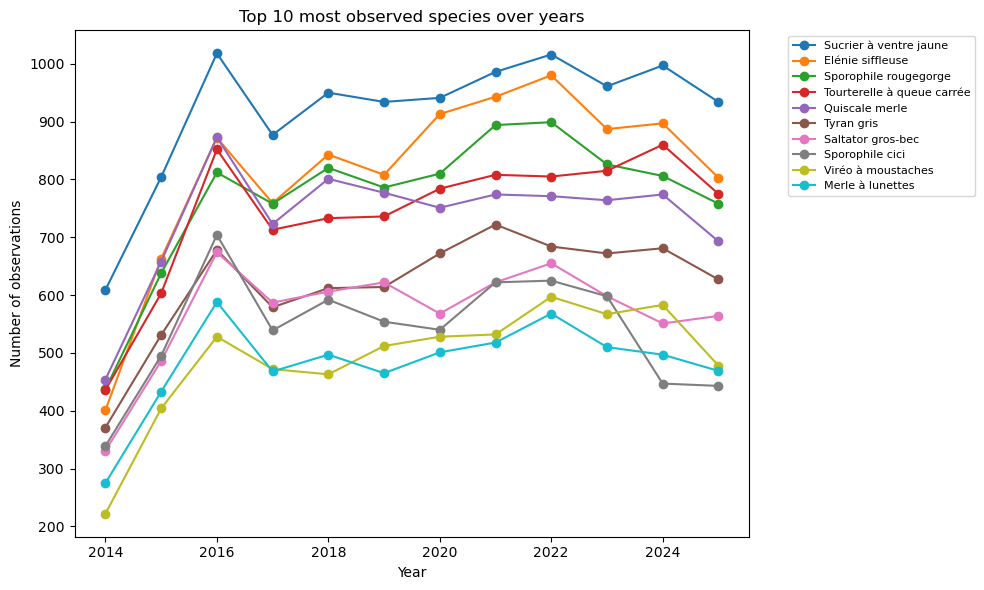

In [17]:
# Count number of observations per species per year 
species_year_counts = (
    df.groupby(["ESPECE", "year"])
      .size()
      .reset_index(name="N_observations")
      .sort_values(["ESPECE", "year"])
)

display(species_year_counts.head(10))

# Total number of years each species was observed 
species_total = (
    species_year_counts.groupby("ESPECE")["year"]
      .nunique()
      .reset_index(name="N_years_observed")
      .sort_values("N_years_observed", ascending=False)
)
display(species_total.head(10))

# Top 10 most observed species over time
top_species = (
    species_year_counts.groupby("ESPECE")["N_observations"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

plt.figure(figsize=(10,6))
for specie in top_species:
    subset = species_year_counts[species_year_counts["ESPECE"] == specie]
    plt.plot(subset["year"], subset["N_observations"], marker="o", label=specie)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.title("Top 10 most observed species over years")
plt.xlabel("Year")
plt.ylabel("Number of observations")
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "top_obs_species_over_time.png")
plt.show()


FAMILY    year  N_observations
0  Aigrette  2014.0               7
1  Aigrette  2015.0              15
2  Aigrette  2016.0              26
3  Aigrette  2017.0              17
4  Aigrette  2018.0              25
5  Aigrette  2019.0              26
6  Aigrette  2020.0              21
7  Aigrette  2021.0              15
8  Aigrette  2022.0              15
9  Aigrette  2023.0              17

FAMILY  N_years_observed
0    Aigrette                12
1     Amazone                12
2     Astrild                12
5    Bihoreau                12
19  Gallinule                12
10    Colibri                12
9   Chevalier                12
8     Capucin                12
11    Colombe                12
18    Frégate                12

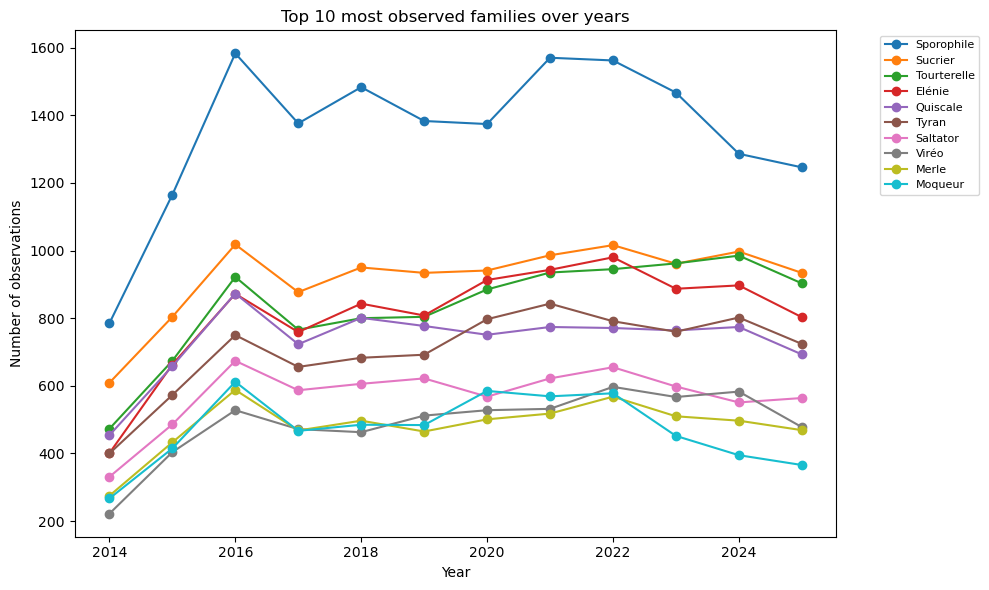

In [18]:
# Create dict ESPECE (name) -> family
df_clean_especes["ESPECIES_FAMILY"] = df_clean_especes["ESPECIES_NAME"].str.split().str[0]
species_to_family = dict(zip(df_clean_especes["ESPECIES_NAME"], df_clean_especes["ESPECIES_FAMILY"]))

# Map to observations table
df["FAMILY"] = df["ESPECE"].map(species_to_family)

# Count observations per family per year 
family_year_counts = (
    df.groupby(["FAMILY", "year"])
      .size()
      .reset_index(name="N_observations")
      .sort_values(["FAMILY", "year"])
)

display(family_year_counts.head(10))

# Total number of years each family observed 
family_total = (
    family_year_counts.groupby("FAMILY")["year"]
      .nunique()
      .reset_index(name="N_years_observed")
      .sort_values("N_years_observed", ascending=False)
)
display(family_total.head(10))

# Plot top 10 most observed families
top_families = (
    family_year_counts.groupby("FAMILY")["N_observations"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

plt.figure(figsize=(10,6))
for fam in top_families:
    subset = family_year_counts[family_year_counts["FAMILY"] == fam]
    plt.plot(subset["year"], subset["N_observations"], marker="o", label=fam)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.title("Top 10 most observed families over years")
plt.xlabel("Year")
plt.ylabel("Number of observations")
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "top_obs_families_over_time.png")
plt.show()


# Multi-Year Indicator Trends
---

### Species Diversity

In [19]:
# Aggregate bird counts per species per year
year_species_counts = (
    df.groupby(["year", "ESPECE"])["TOT_AV_sV"]
      .sum()
      .reset_index()
)

# Aggregate per year using .agg to produce flat columns
diversity_year = (
    year_species_counts.groupby("year")["TOT_AV_sV"]
    .agg(
        Shannon=lambda x: shannon_index(x),
        Simpson=lambda x: simpson_index(x),
        Richness=lambda x: (x > 0).sum(),
        Total_birds="sum"
    )
    .reset_index()
)

display(diversity_year)

year   Shannon   Simpson  Richness  Total_birds
0   2014.0  2.946971  0.918521        61        10713
1   2015.0  3.048411  0.926885        64        17319
2   2016.0  3.045182  0.926049        74        22888
3   2017.0  3.016821  0.925098        71        20519
4   2018.0  2.994555  0.923016        71        20325
5   2019.0  3.011572  0.924549        70        21005
6   2020.0  3.039662  0.928024        67        21986
7   2021.0  3.040355  0.928734        67        23914
8   2022.0  3.030549  0.929514        66        24416
9   2023.0  3.053052  0.930277        67        22269
10  2024.0  3.030088  0.927285        67        21591
11  2025.0  3.107287  0.933989        71        19884

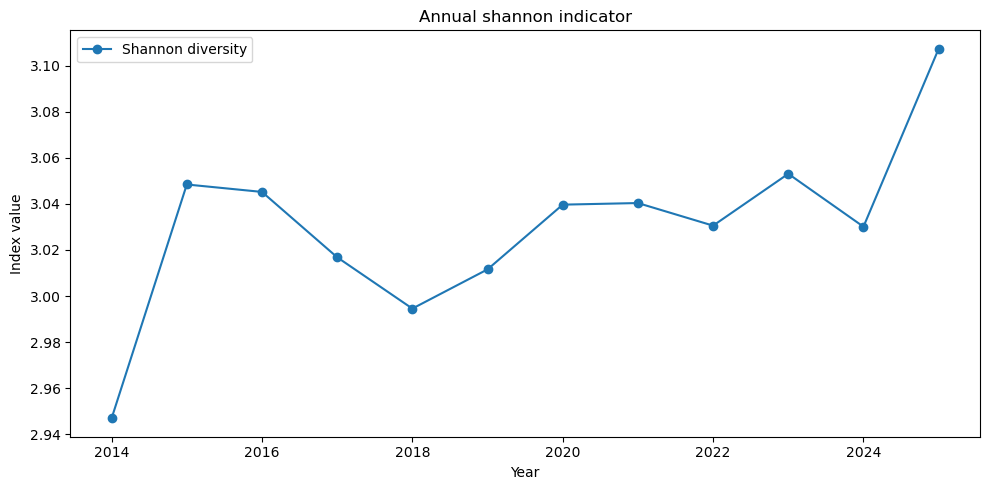

In [20]:
# Plot diversity indices over years
plt.figure(figsize=(10,5))
plt.plot(diversity_year["year"], diversity_year["Shannon"], marker="o", label="Shannon diversity")
plt.legend()
plt.title("Annual shannon indicator")
plt.xlabel("Year")
plt.ylabel("Index value")
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "annual_shannon_index.png")
plt.show()


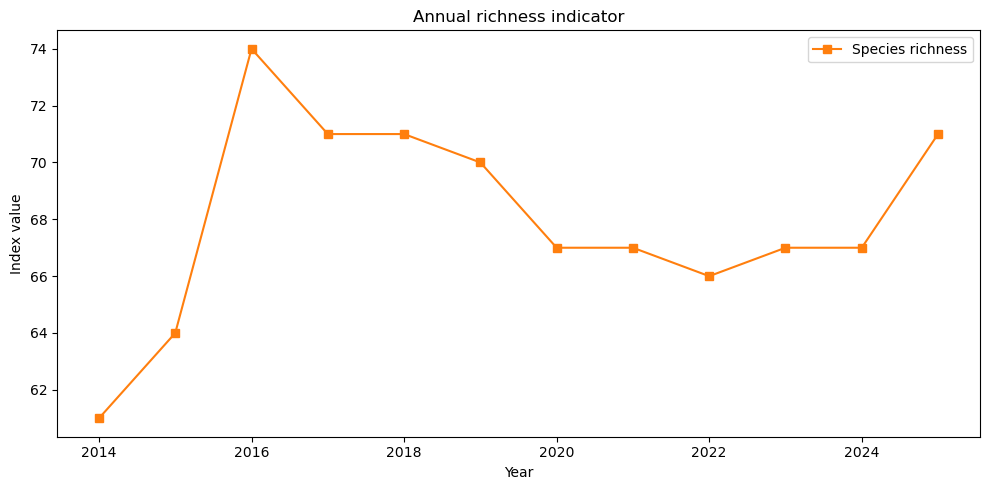

In [21]:
# Plot diversity indices over years
plt.figure(figsize=(10,5))
plt.plot(diversity_year["year"], diversity_year["Richness"], marker="s", label="Species richness", color="tab:orange")
plt.legend()
plt.title("Annual richness indicator")
plt.xlabel("Year")
plt.ylabel("Index value")
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "annual_richness_index.png")
plt.show()


In [22]:
# OLS Regression
X = sm.add_constant(diversity_year["year"])
model = sm.OLS(diversity_year["Shannon"], X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                Shannon   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     6.419
Date:                Thu, 06 Nov 2025   Prob (F-statistic):             0.0297
Time:                        22:02:03   Log-Likelihood:                 25.692
No. Observations:                  12   AIC:                            -47.38
Df Residuals:                      10   BIC:                            -46.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.2997      5.261     -1.958      0.0

In [23]:
X = sm.add_constant(diversity_year["year"])
model = sm.OLS(diversity_year['Simpson'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Simpson   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     17.03
Date:                Thu, 06 Nov 2025   Prob (F-statistic):            0.00205
Time:                        22:02:03   Log-Likelihood:                 55.998
No. Observations:                  12   AIC:                            -108.0
Df Residuals:                      10   BIC:                            -107.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8106      0.421     -1.925      0.0

In [24]:
X = sm.add_constant(diversity_year["year"])
model = sm.OLS(diversity_year['Richness'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Richness   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.068
Method:                 Least Squares   F-statistic:                    0.2962
Date:                Thu, 06 Nov 2025   Prob (F-statistic):              0.598
Time:                        22:02:03   Log-Likelihood:                -31.593
No. Observations:                  12   AIC:                             67.19
Df Residuals:                      10   BIC:                             68.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -270.9371    622.732     -0.435      0.6

In [25]:
#  Compute diversity and bootstrap CIs per year 
records = []
for year, sub in year_species_counts.groupby("year"):
    ci = bootstrap_diversity(sub)
    records.append({
        "year": year,
        "Shannon": ci.loc["Shannon", "mean"],
        "Shannon_low": ci.loc["Shannon", "ci_low"],
        "Shannon_high": ci.loc["Shannon", "ci_high"],
        "Simpson": ci.loc["Simpson", "mean"],
        "Simpson_low": ci.loc["Simpson", "ci_low"],
        "Simpson_high": ci.loc["Simpson", "ci_high"],
        "Richness": ci.loc["Richness", "mean"],
        "Richness_low": ci.loc["Richness", "ci_low"],
        "Richness_high": ci.loc["Richness", "ci_high"]
    })

diversity_boot = pd.DataFrame(records)
display(diversity_boot.head())

year   Shannon  Shannon_low  Shannon_high   Simpson  Simpson_low  \
0  2014.0  2.978878     2.676385      3.251518  0.920573     0.882347   
1  2015.0  3.069436     2.798562      3.319134  0.927852     0.896088   
2  2016.0  3.070719     2.782250      3.328367  0.927350     0.894382   
3  2017.0  3.043192     2.775195      3.290778  0.926186     0.892489   
4  2018.0  3.020298     2.715019      3.274737  0.924691     0.888218   

   Simpson_high  Richness  Richness_low  Richness_high  
0      0.946147    61.018          57.0           64.0  
1      0.949484    64.166          59.0           68.0  
2      0.950251    74.002          70.0           77.0  
3      0.947962    71.000          71.0           71.0  
4      0.948450    71.062          68.0           73.0

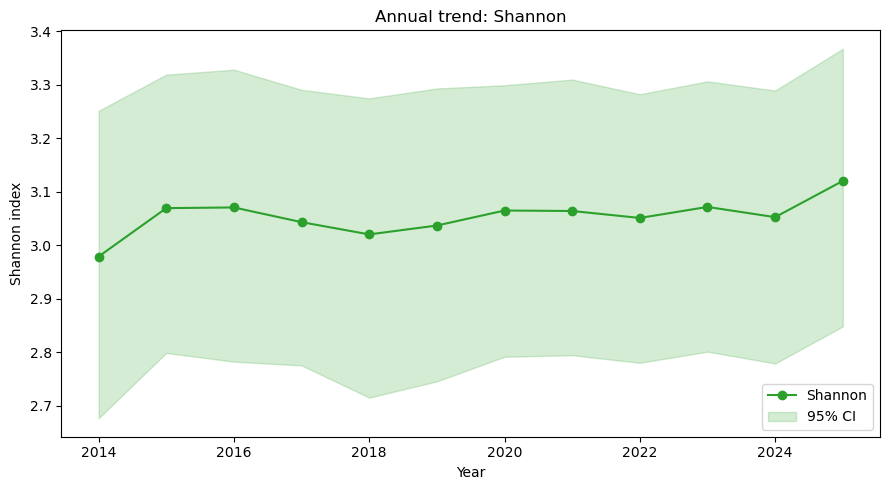

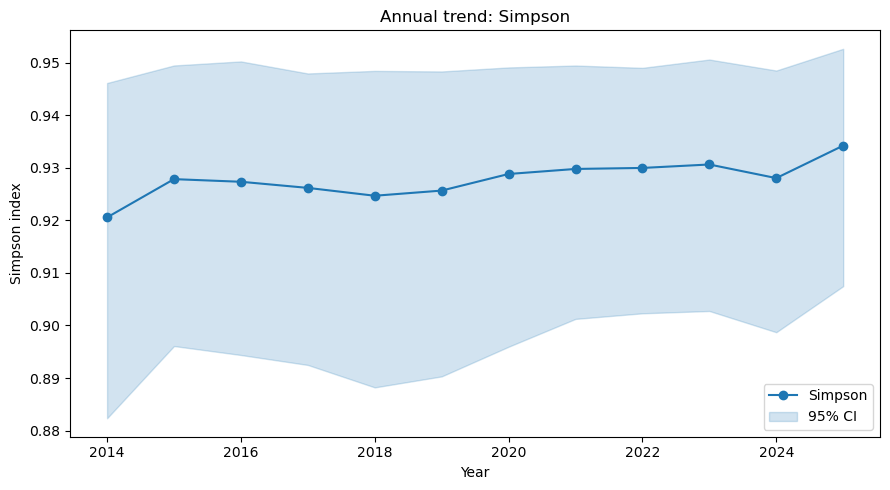

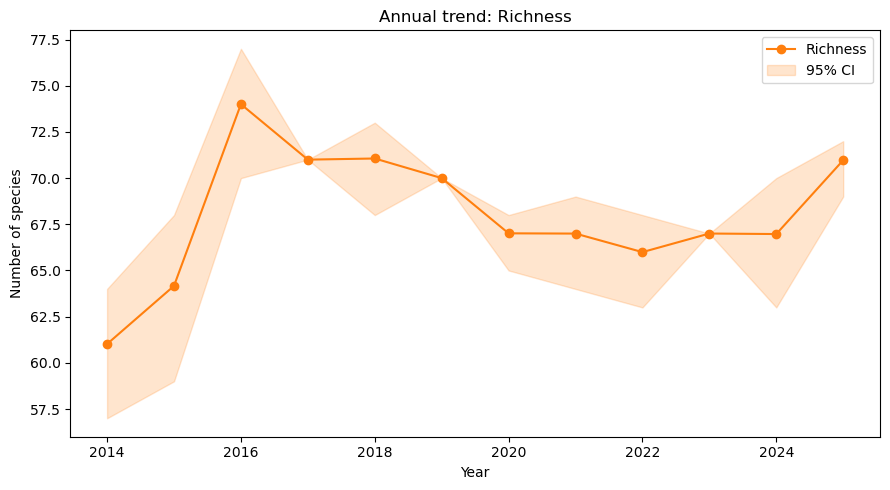

In [26]:
plot_indicator_with_ci(diversity_boot, "Shannon", "tab:green", "Shannon index", first_execution=first_execution, OUT_FIG=OUT_FIG)
plot_indicator_with_ci(diversity_boot, "Simpson", "tab:blue", "Simpson index", first_execution=first_execution, OUT_FIG=OUT_FIG)
plot_indicator_with_ci(diversity_boot, "Richness", "tab:orange", "Number of species", first_execution=first_execution, OUT_FIG=OUT_FIG)


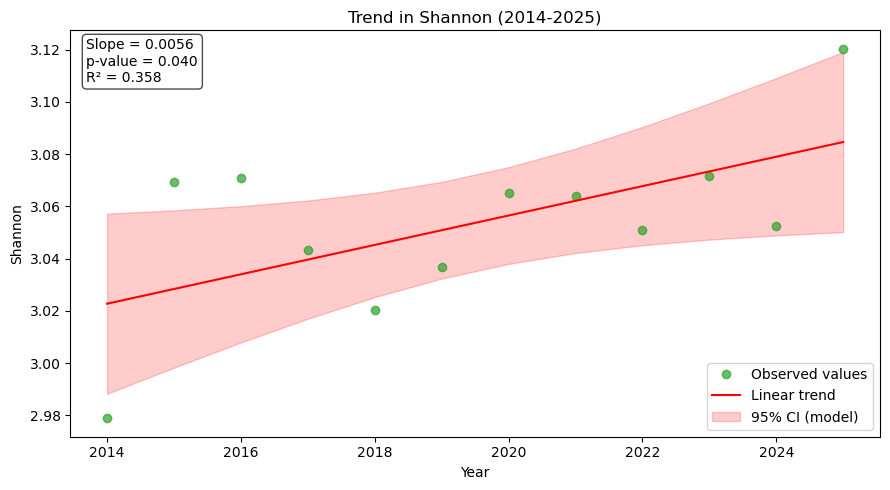

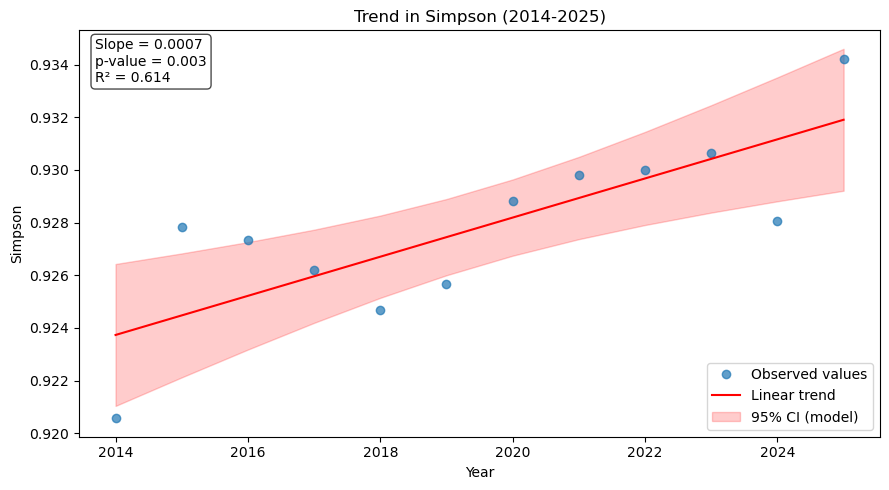

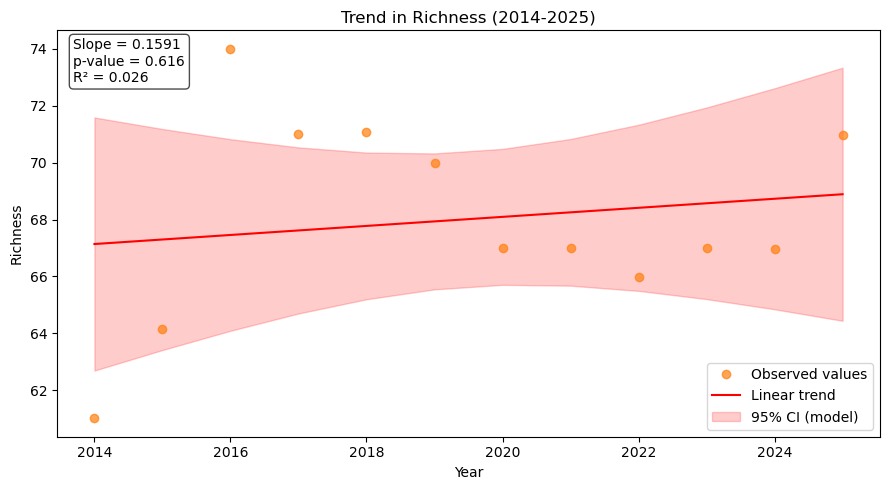

In [27]:
#  Usage for all three indicators 
model_shannon = plot_trend_with_stats(diversity_boot, "Shannon", color="tab:green", first_execution=first_execution, OUT_FIG=OUT_FIG)
model_simpson = plot_trend_with_stats(diversity_boot, "Simpson", color="tab:blue", first_execution=first_execution, OUT_FIG=OUT_FIG)
model_richness = plot_trend_with_stats(diversity_boot, "Richness", color="tab:orange", first_execution=first_execution, OUT_FIG=OUT_FIG)


### Density

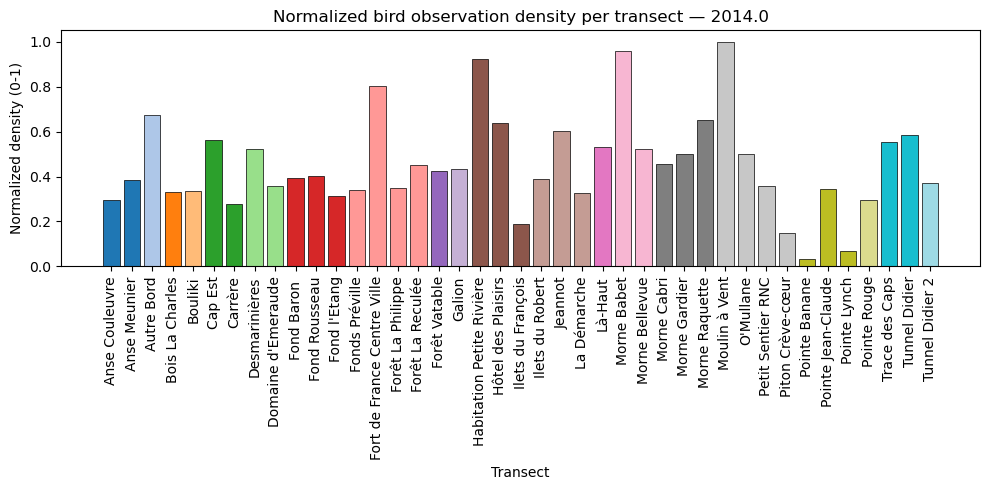

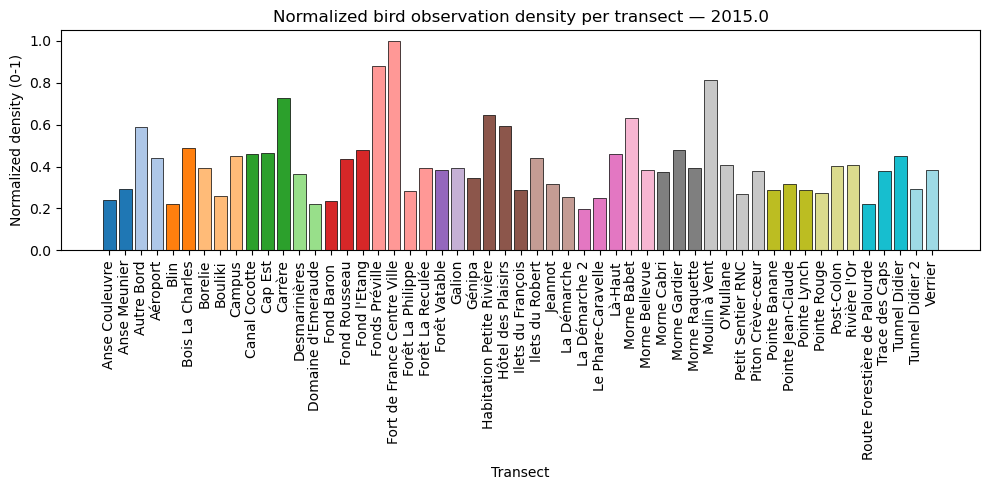

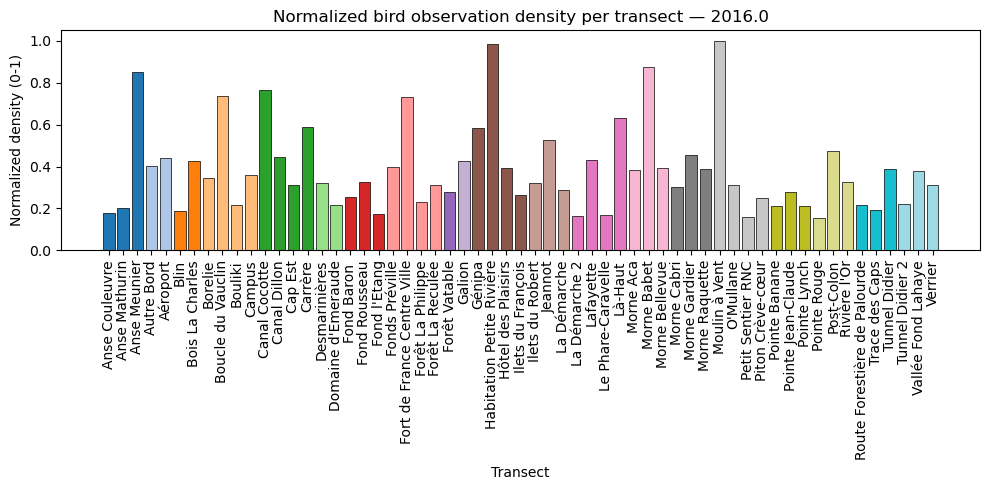

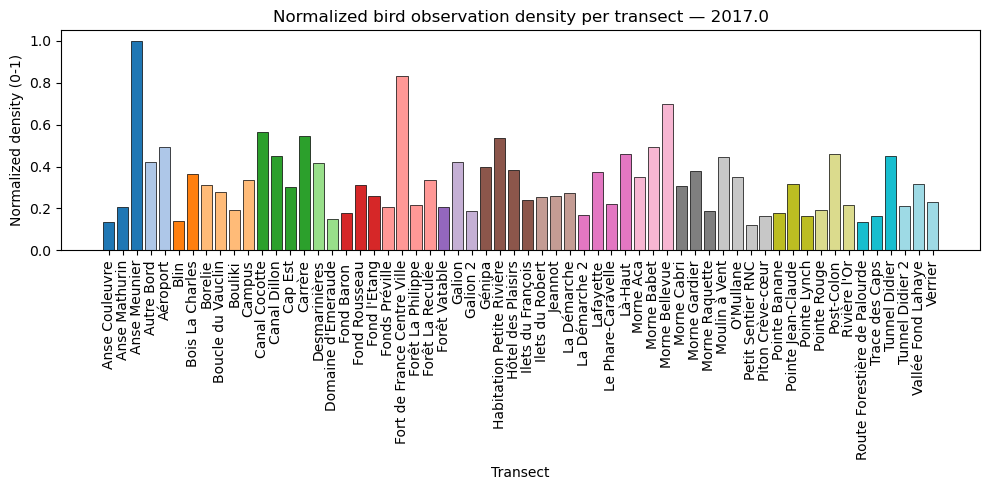

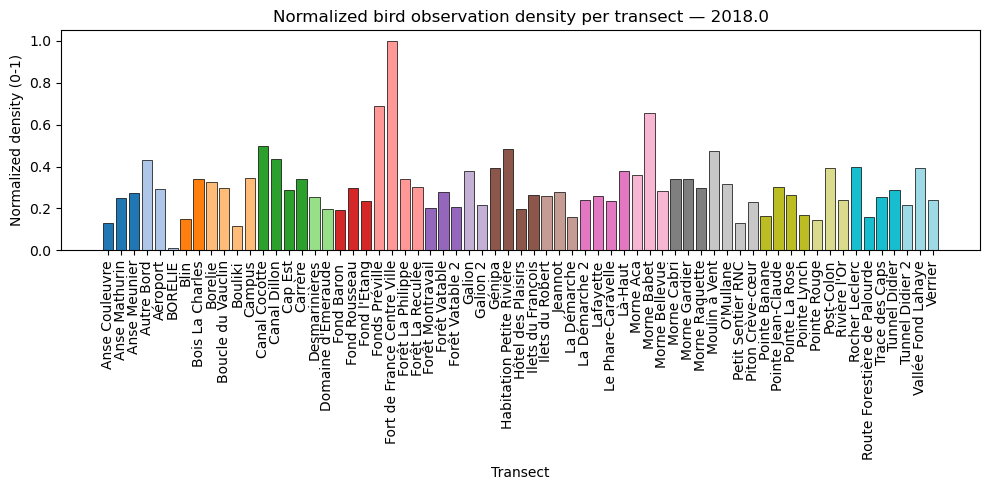

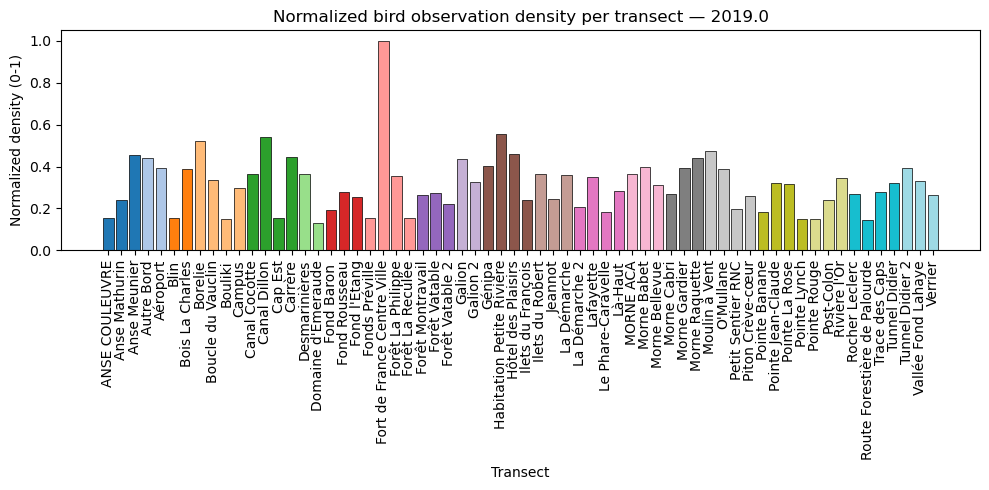

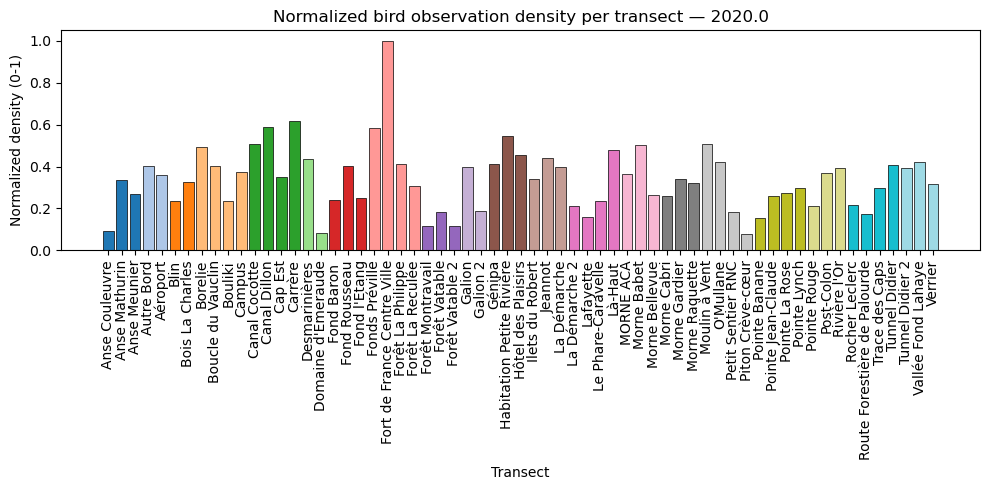

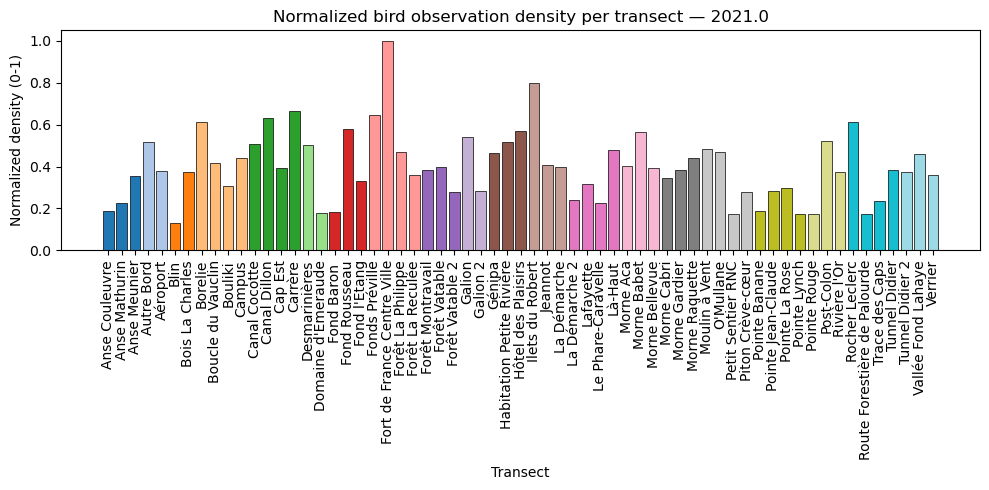

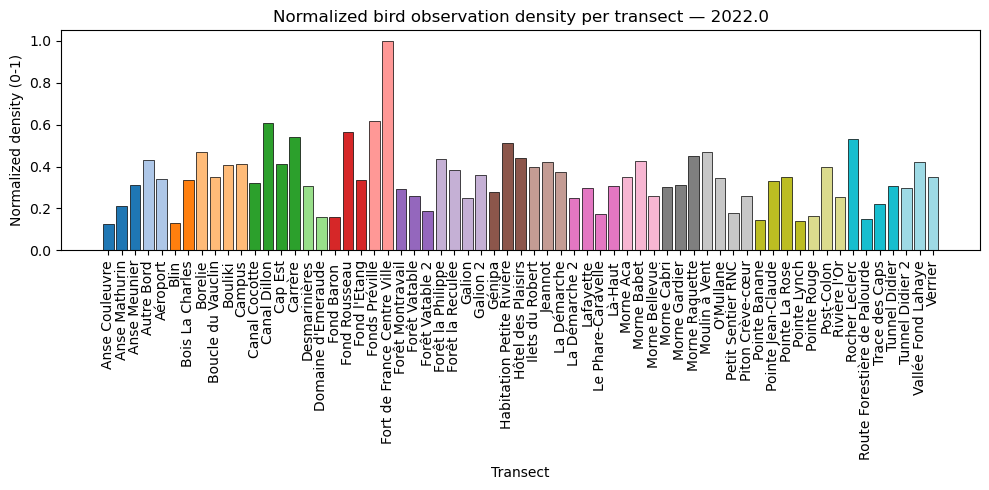

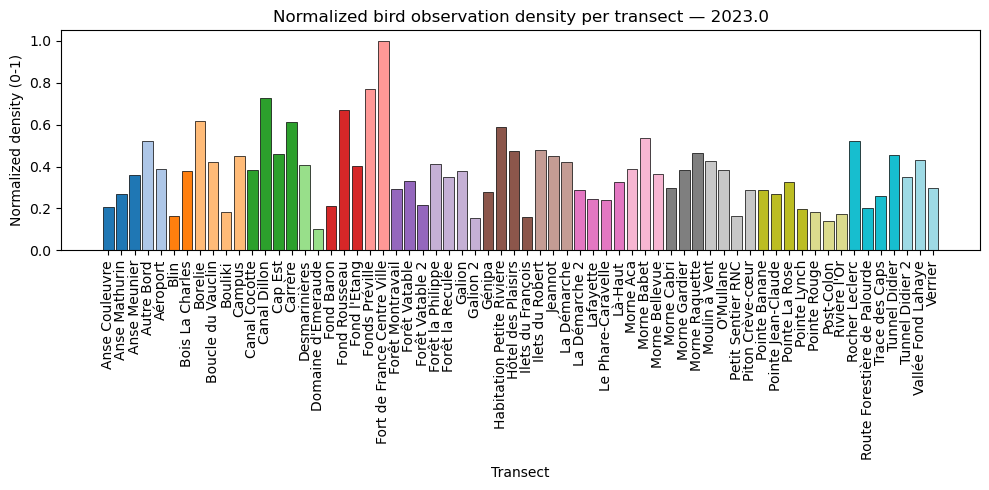

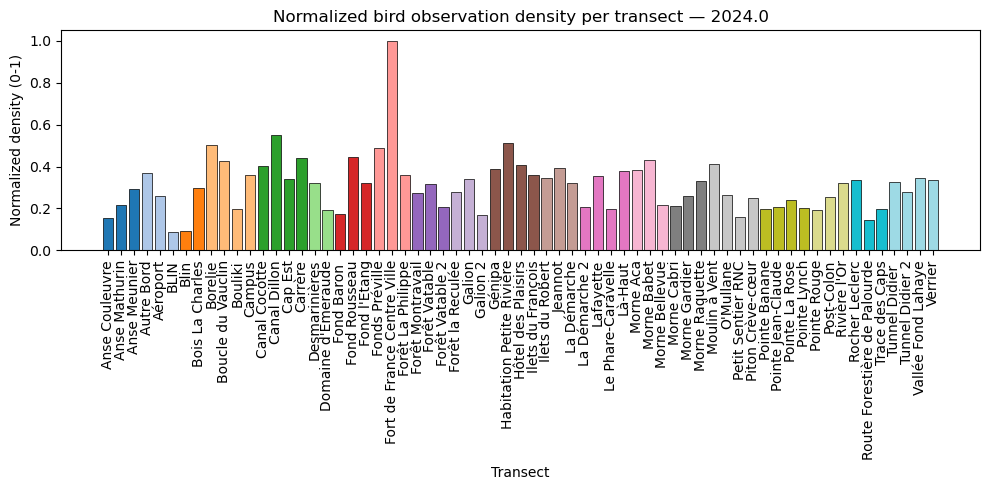

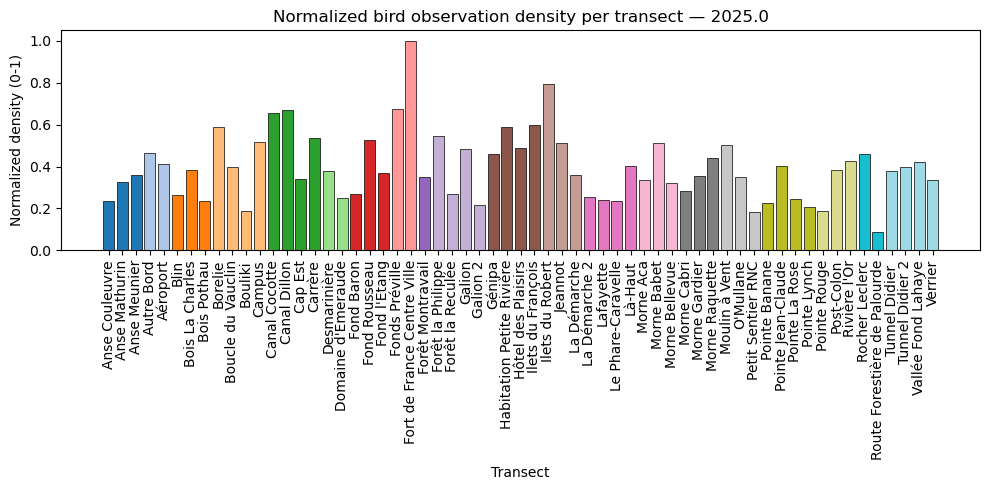

In [28]:
# Compute total birds per transect per year 
transect_year_counts = (
    df.groupby(["year", "Nom transect"])["TOT_AV_sV"]
      .sum()
      .reset_index()
      .rename(columns={"TOT_AV_sV": "Bird_count"})
)

# Normalize counts per year 
transect_year_counts["Normalized_density"] = transect_year_counts.groupby("year")["Bird_count"].transform(
    lambda x: x / x.max()
)
# Colors 
transects = sorted(transect_year_counts["Nom transect"].unique())
colors = plt.cm.tab20(np.linspace(0, 1, len(transects)))  
color_map = dict(zip(transects, colors))

# Plot normalized density distributions per year
years = sorted(transect_year_counts["year"].dropna().unique())

for yr in years:
    subset = transect_year_counts[transect_year_counts["year"] == yr]
    plt.figure(figsize=(10, 5))
    for _, row in subset.iterrows():
        plt.bar(
            row["Nom transect"], 
            row["Normalized_density"], 
            color=color_map[row["Nom transect"]],
            edgecolor="black",
            linewidth=0.5
        )
    plt.title(f"Normalized bird observation density per transect — {yr}")
    plt.xlabel("Transect")
    plt.ylabel("Normalized density (0-1)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    if first_execution:
        plt.savefig(OUT_FIG / f"normalized_density_transects_{yr}.png")
    plt.show()

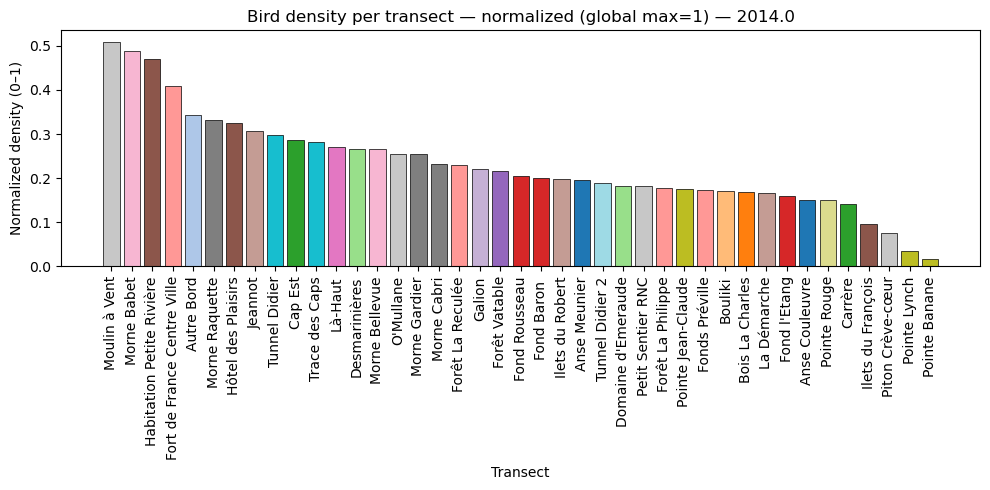

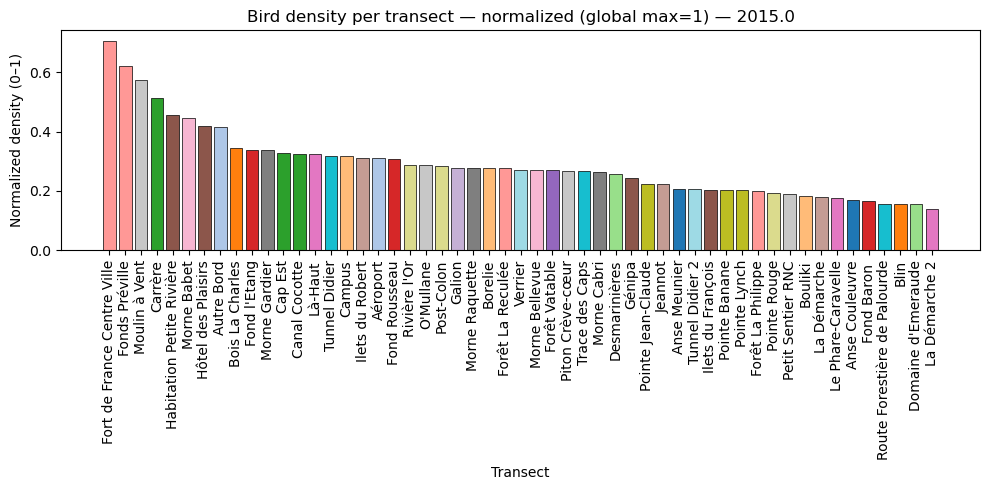

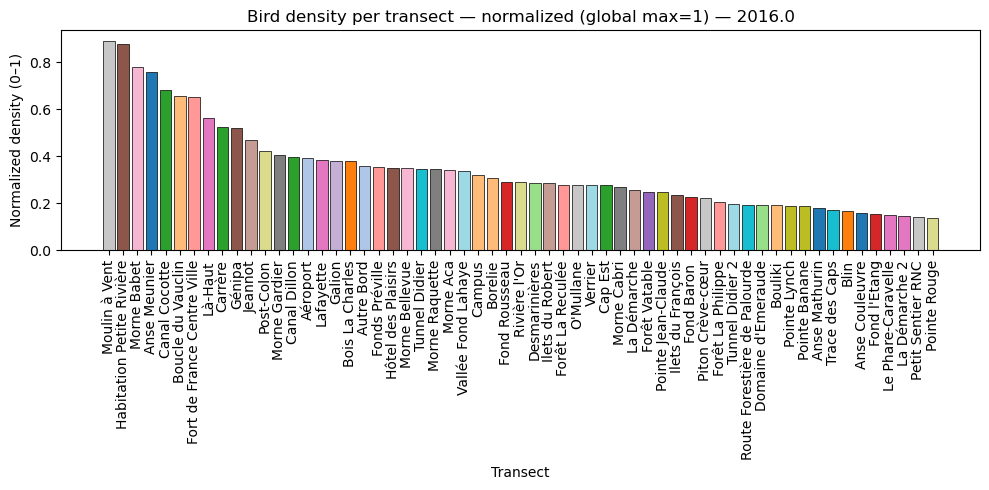

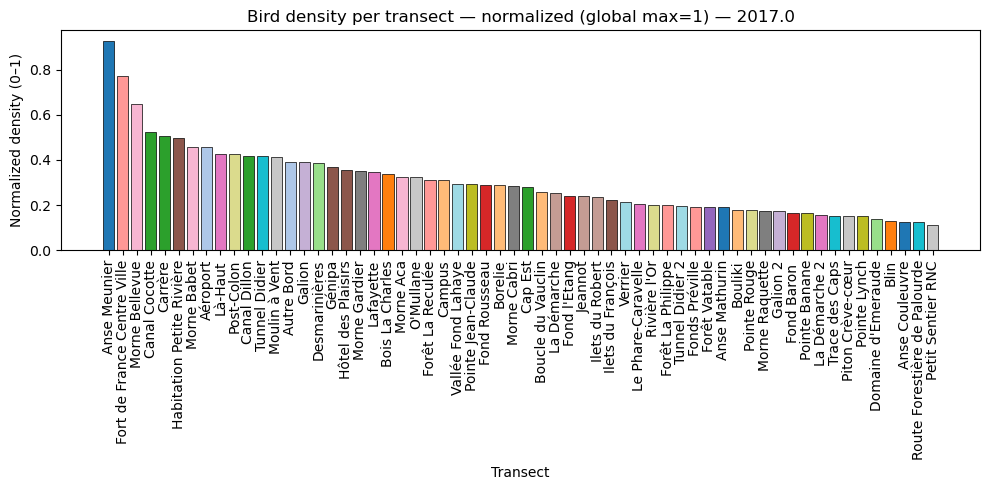

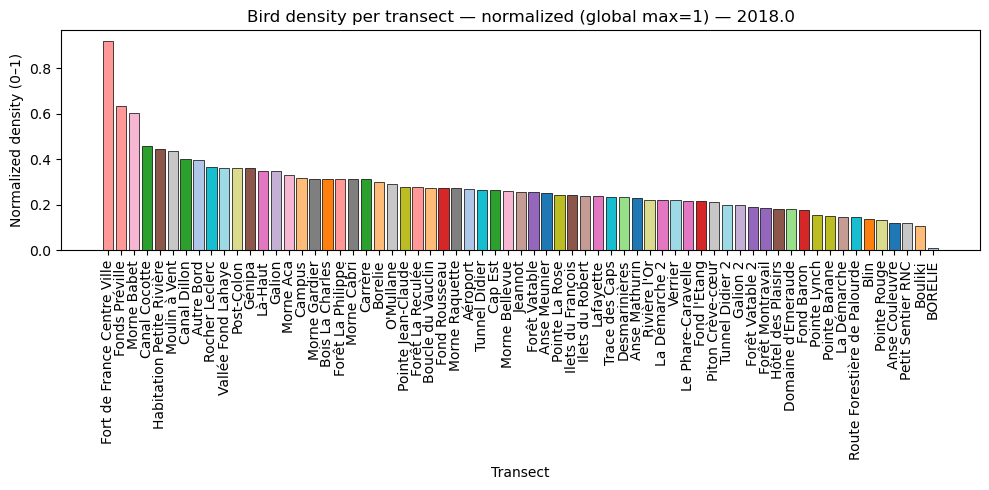

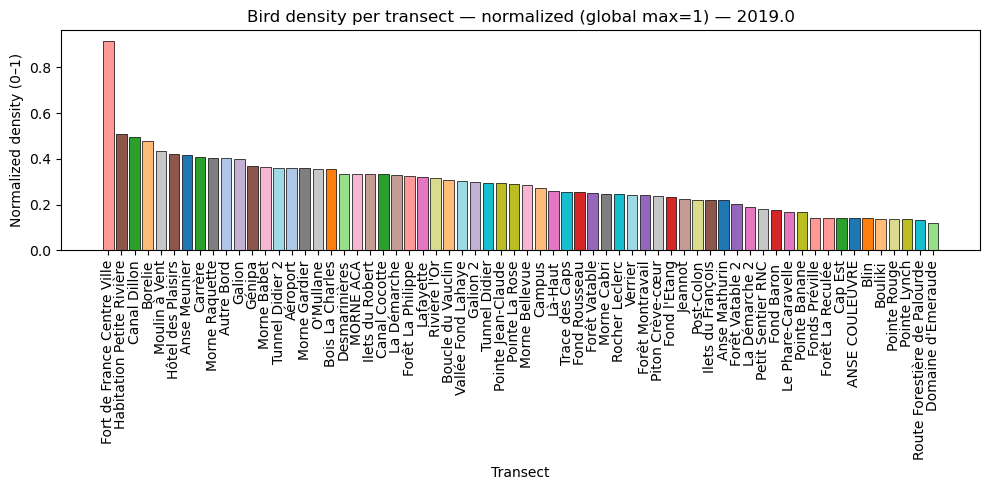

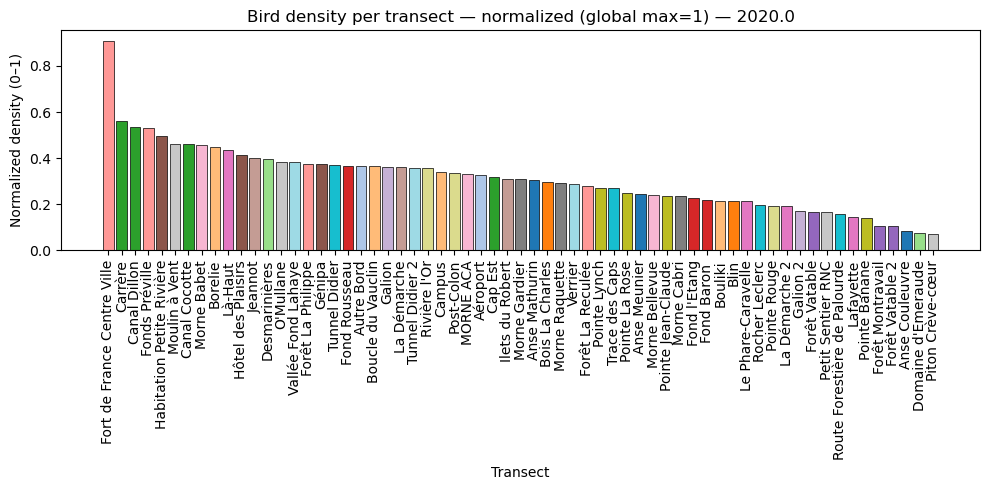

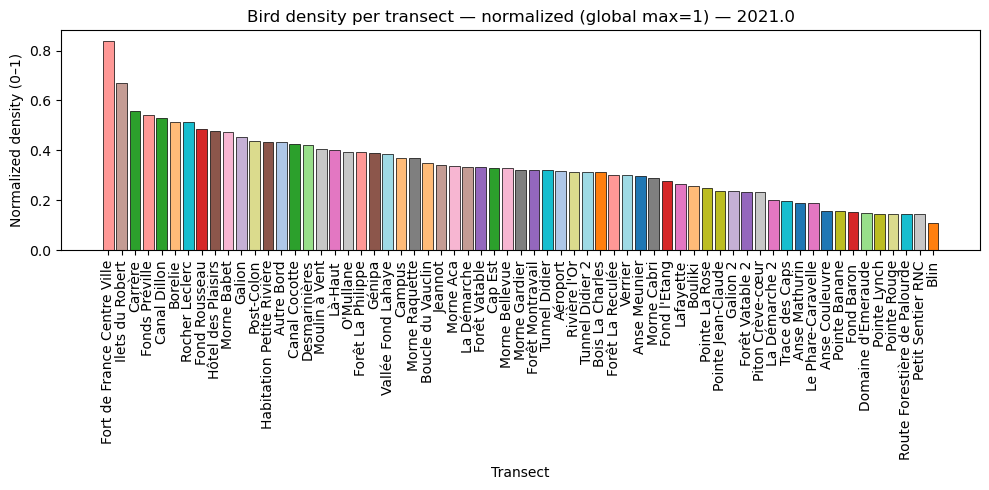

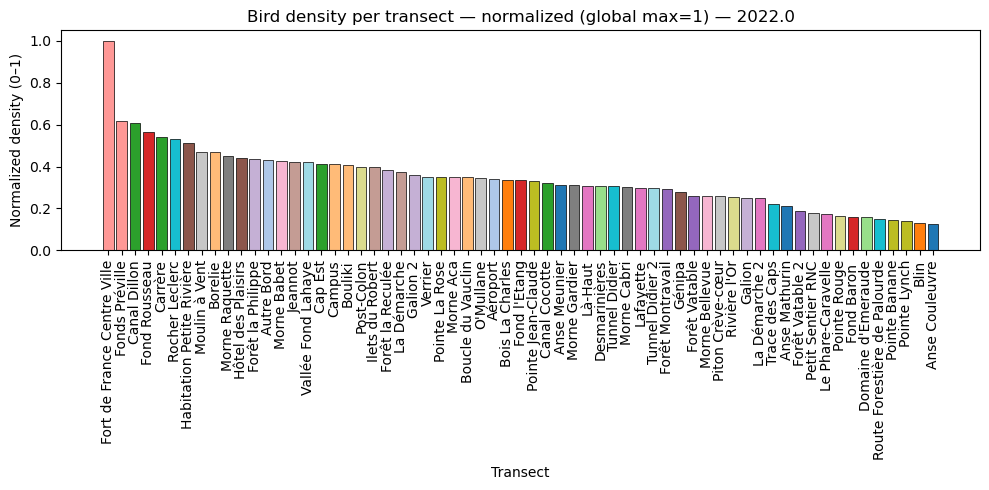

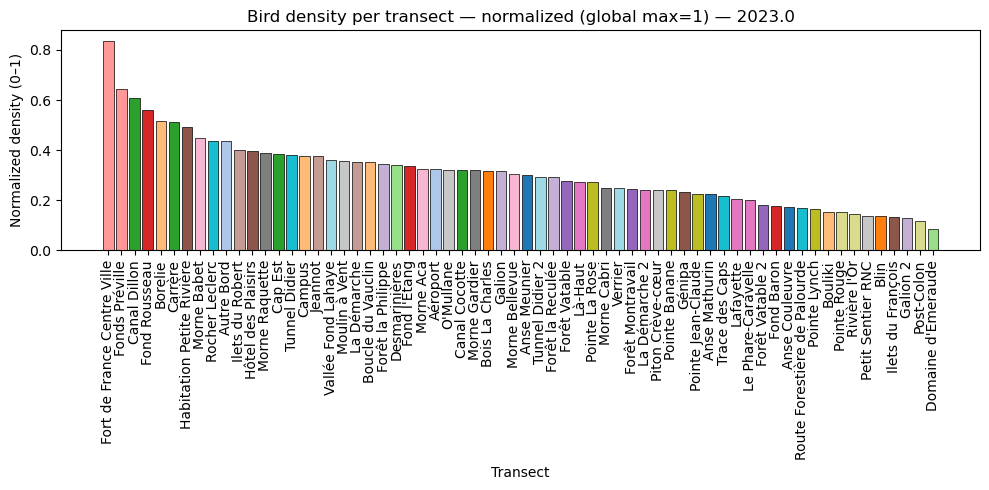

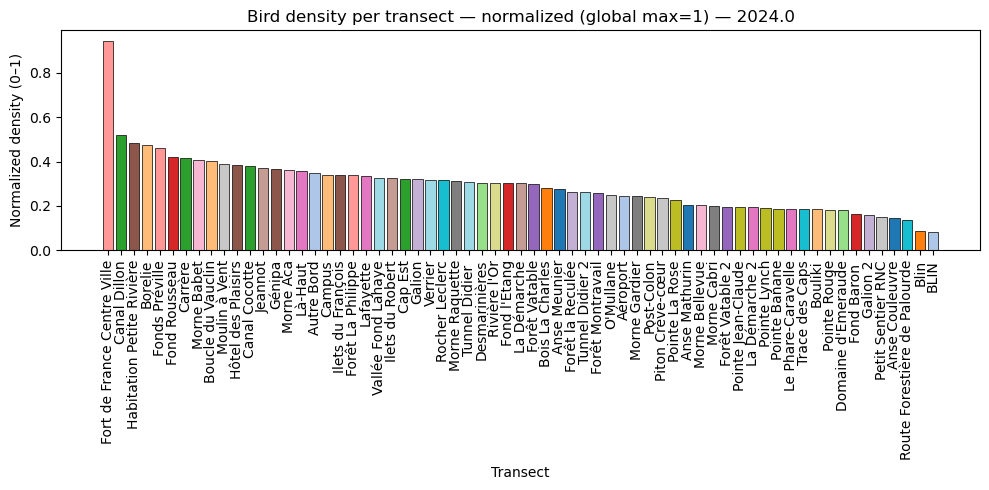

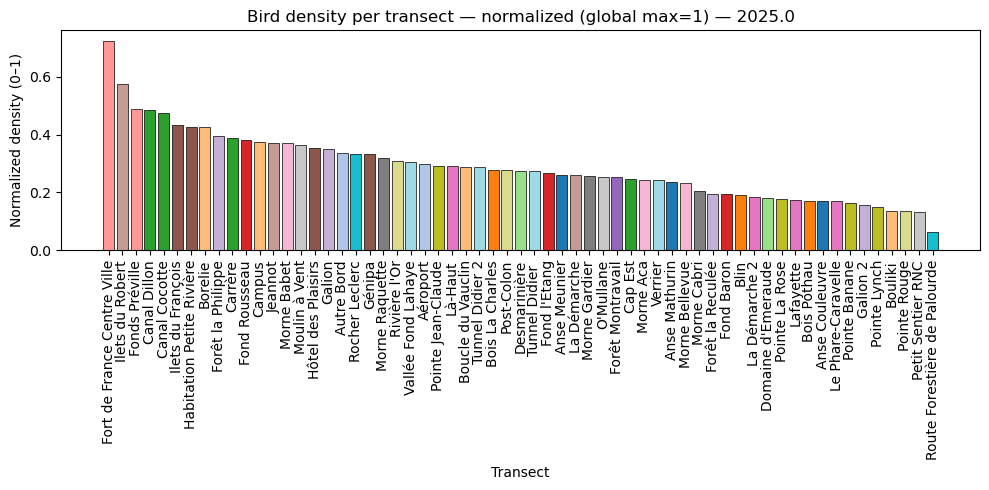

In [29]:
# Normalize globally (using the all-time maximum count) 
global_max = transect_year_counts["Bird_count"].max()
transect_year_counts["Normalized_density"] = transect_year_counts["Bird_count"] / global_max

# Colors 
transects = sorted(transect_year_counts["Nom transect"].unique())
colors = plt.cm.tab20(np.linspace(0, 1, len(transects)))  # up to 20 distinct colors
color_map = dict(zip(transects, colors))

# Plot evolution by year 
years = sorted(transect_year_counts["year"].dropna().unique())

for yr in years:
    subset = transect_year_counts[transect_year_counts["year"] == yr].sort_values("Normalized_density", ascending=False)
    
    plt.figure(figsize=(10, 5))
    for _, row in subset.iterrows():
        plt.bar(
            row["Nom transect"], 
            row["Normalized_density"], 
            color=color_map[row["Nom transect"]],
            edgecolor="black",
            linewidth=0.5
        )
    
    plt.title(f"Bird density per transect — normalized (global max=1) — {yr}")
    plt.xlabel("Transect")
    plt.ylabel("Normalized density (0–1)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    if first_execution:
        plt.savefig(OUT_FIG / f"global_normalized_density_transects_{yr}.png")
    plt.show()

#### Density bootstrap 


year      mean    ci_low   ci_high
0   2014.0  1.992004  1.937705  2.048545
1   2015.0  2.121906  2.059900  2.175591
2   2016.0  2.078649  2.040684  2.119349
3   2017.0  2.223559  2.170194  2.269183
4   2018.0  2.088256  2.031334  2.139227
5   2019.0  2.194421  2.138315  2.244259
6   2020.0  2.208317  2.142407  2.261553
7   2021.0  2.255187  2.195271  2.315355
8   2022.0  2.259904  2.205107  2.313794
9   2023.0  2.178110  2.122066  2.222819
10  2024.0  2.148144  2.098761  2.192518
11  2025.0  2.145910  2.069137  2.221897

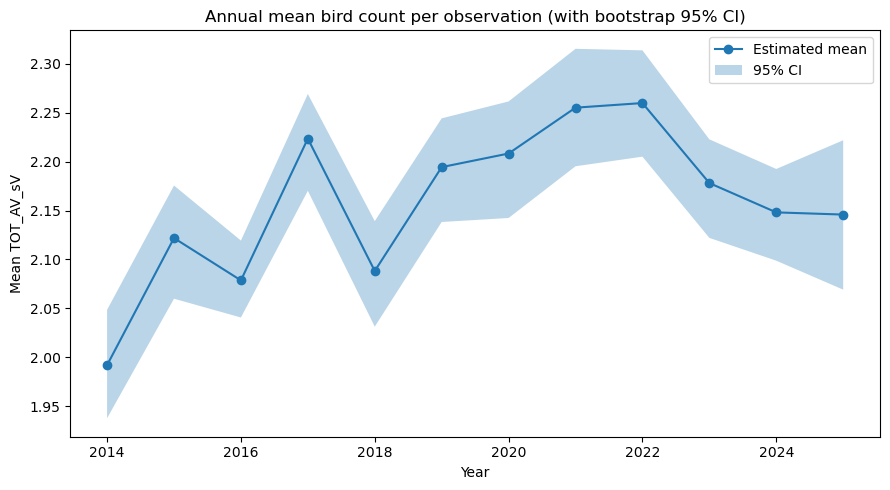

In [30]:
#  Parameters 
B = 1000  # number of bootstrap samples
alpha = 0.05  # for 95% CI

#  Apply bootstrap per year 
bootstrap_results = []
for year, group in df.groupby("year"):
    theta_hat, ci_low, ci_high = bootstrap_ci(group["TOT_AV_sV"].values, func=np.mean, B=B, alpha=alpha)
    bootstrap_results.append({"year": year, "mean": theta_hat, "ci_low": ci_low, "ci_high": ci_high})

bootstrap_df = pd.DataFrame(bootstrap_results).sort_values("year")
display(bootstrap_df)

# Plot results
plt.figure(figsize=(9, 5))
plt.plot(bootstrap_df["year"], bootstrap_df["mean"], marker="o", label="Estimated mean")
plt.fill_between(bootstrap_df["year"], bootstrap_df["ci_low"], bootstrap_df["ci_high"], alpha=0.3, label="95% CI")
plt.title("Annual mean bird count per observation (with bootstrap 95% CI)")
plt.xlabel("Year")
plt.ylabel("Mean TOT_AV_sV")
plt.legend()
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "annual_mean_bird_count_bootstrap_ci.png")
plt.show()

In [31]:
# Compute bootstrap estimates per transect-year
bootstrap_results = []
for (year, transect), group in df.groupby(["year", "Nom transect"]):
    theta_hat, ci_low, ci_high = bootstrap_ci(group["TOT_AV_sV"].values, func=np.sum, B=1000, alpha=0.05)
    bootstrap_results.append({
        "year": year,
        "transect": transect,
        "total_birds": theta_hat,
        "ci_low": ci_low,
        "ci_high": ci_high
    })

bootstrap_df = pd.DataFrame(bootstrap_results)

# Normalize by global maximum total (for comparable densities)
global_max = bootstrap_df["total_birds"].max()
bootstrap_df["density_norm"] = bootstrap_df["total_birds"] / global_max
bootstrap_df["ci_low_norm"] = bootstrap_df["ci_low"] / global_max
bootstrap_df["ci_high_norm"] = bootstrap_df["ci_high"] / global_max

display(bootstrap_df.head())

year         transect  total_birds   ci_low  ci_high  density_norm  \
0  2014.0   Anse Couleuvre          171  148.975  193.000      0.151327   
1  2014.0     Anse Meunier          221  189.975  249.025      0.195575   
2  2014.0       Autre Bord          389  339.000  432.025      0.344248   
3  2014.0  Bois La Charles          191  174.975  208.000      0.169027   
4  2014.0          Bouliki          194  156.950  223.000      0.171681   

   ci_low_norm  ci_high_norm  
0     0.131836      0.170796  
1     0.168119      0.220376  
2     0.300000      0.382323  
3     0.154845      0.184071  
4     0.138894      0.197345

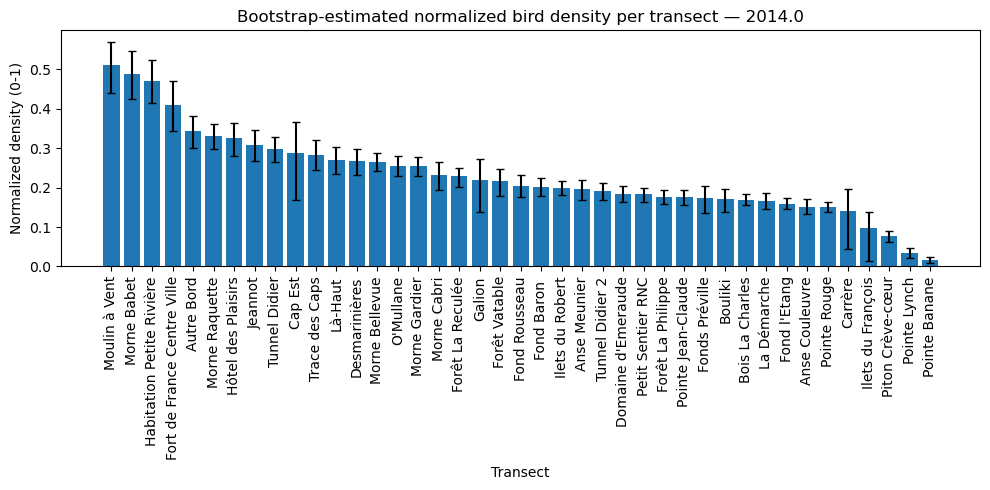

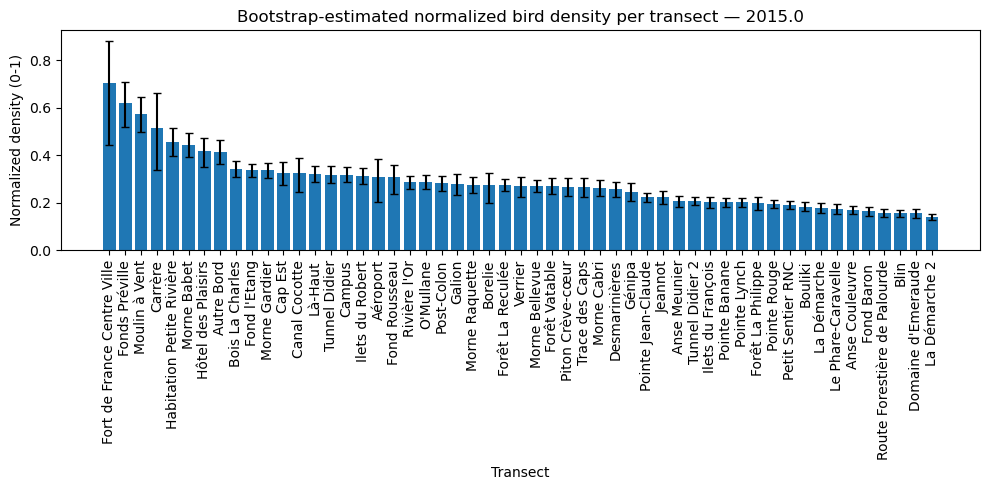

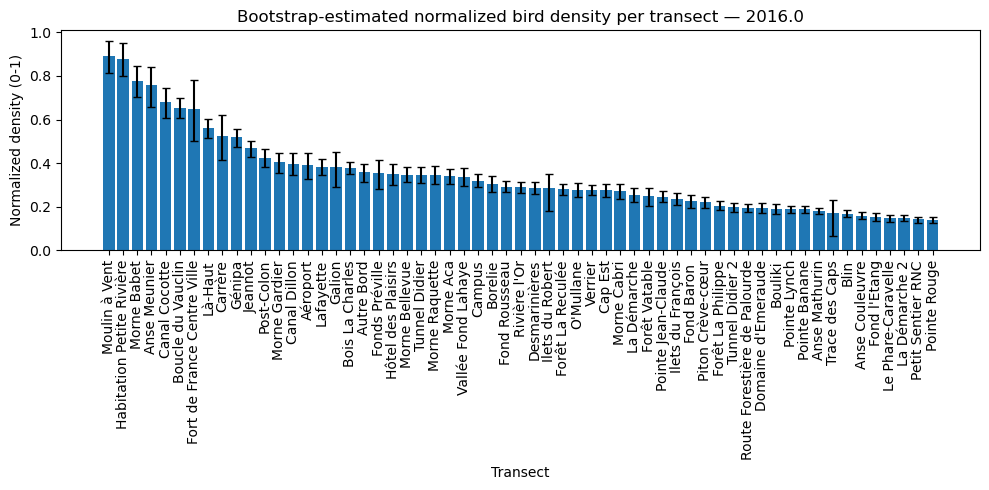

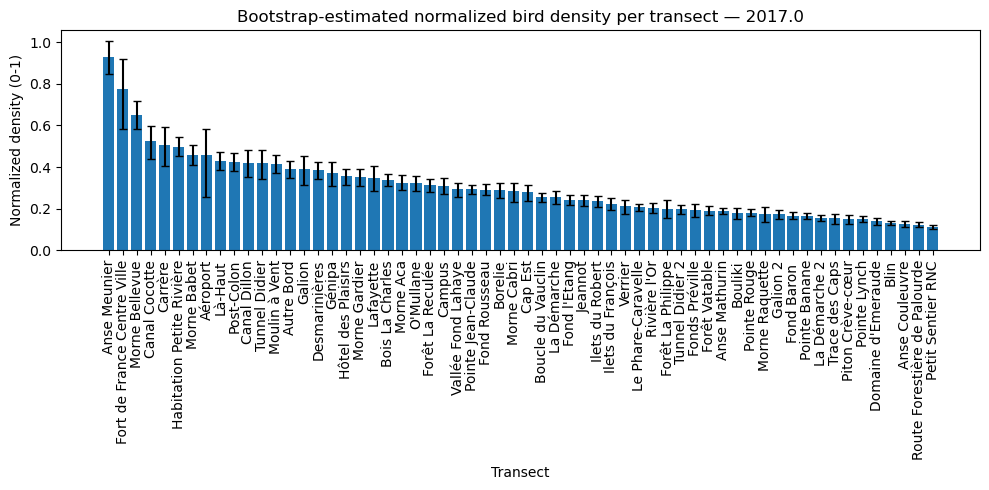

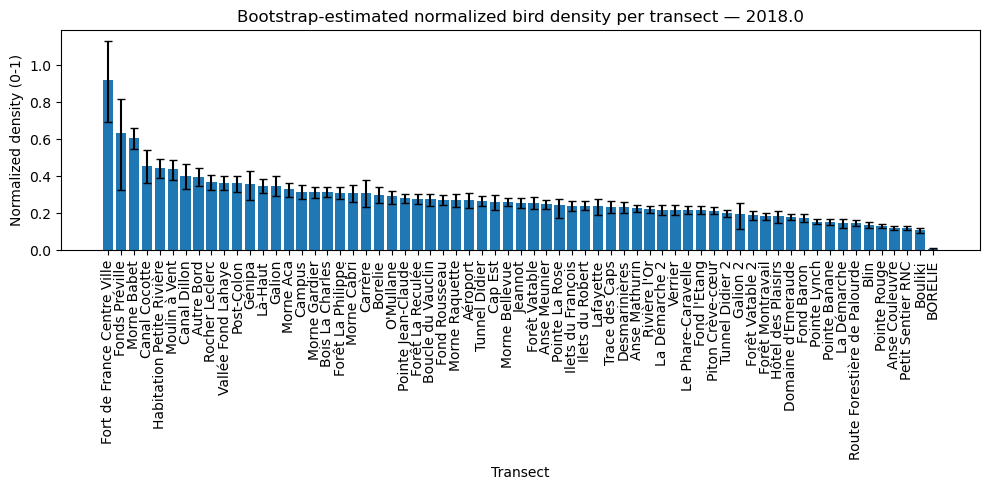

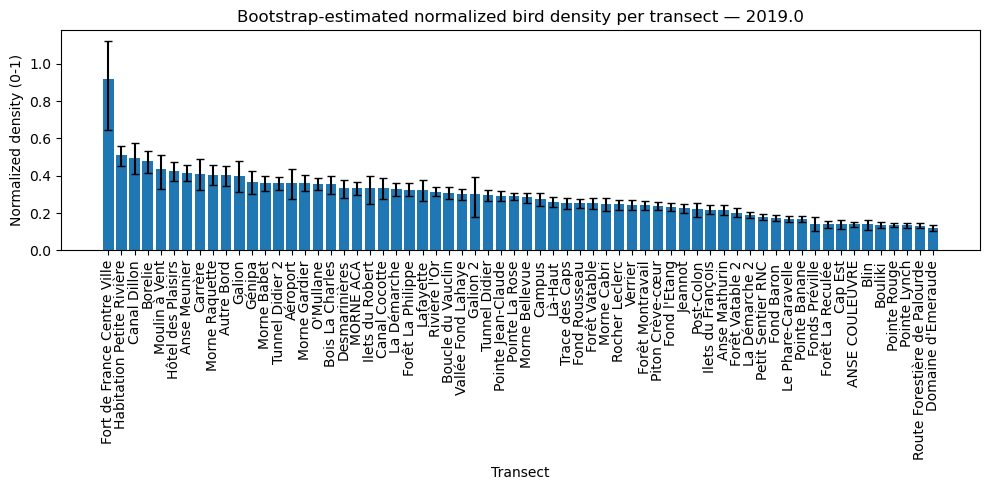

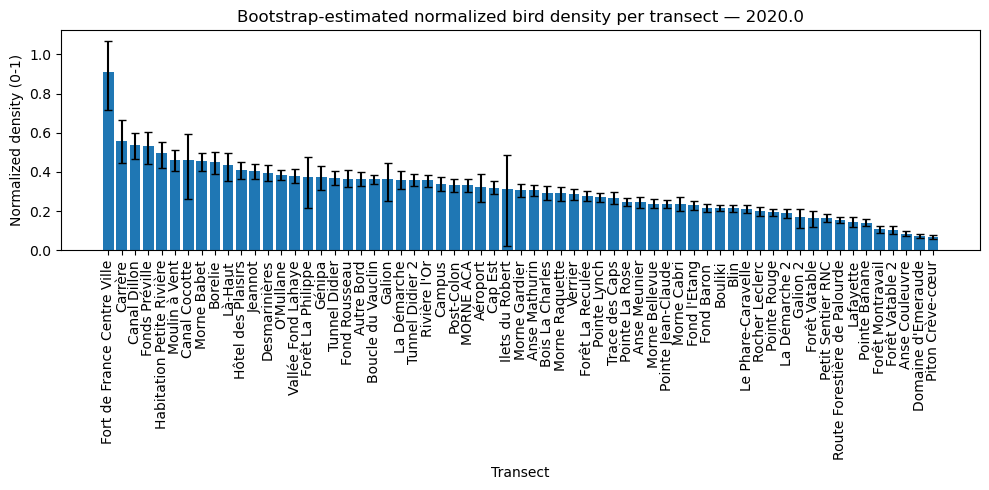

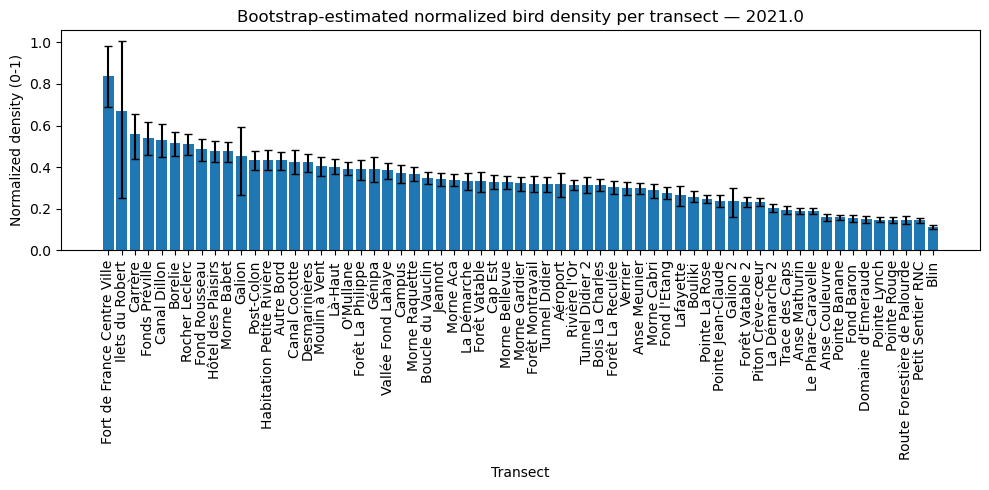

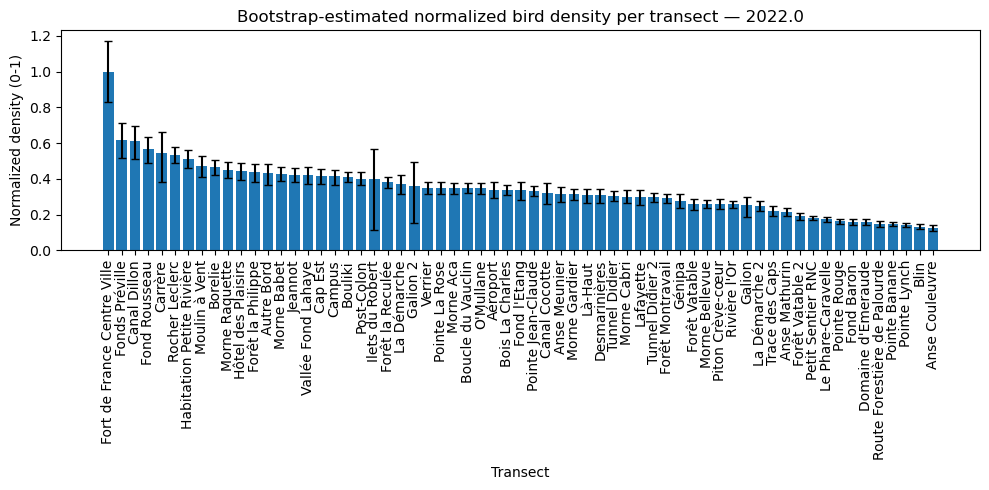

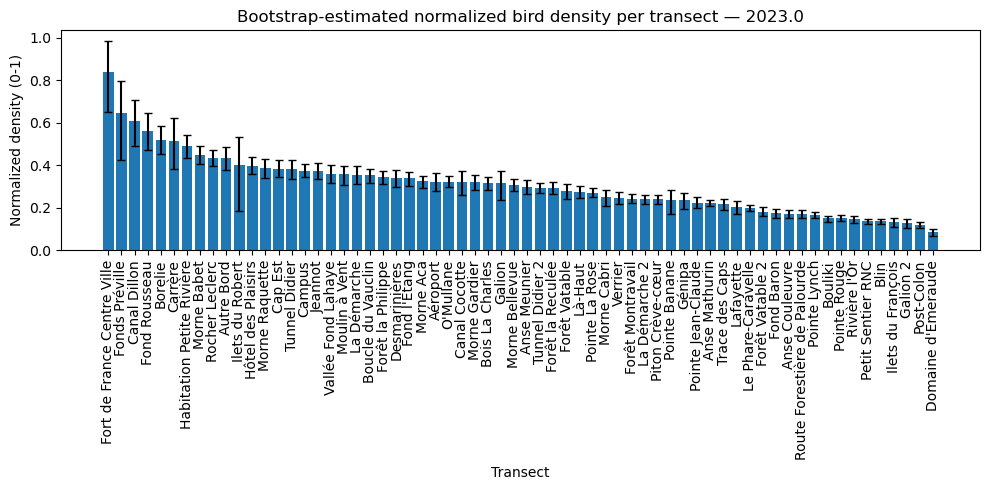

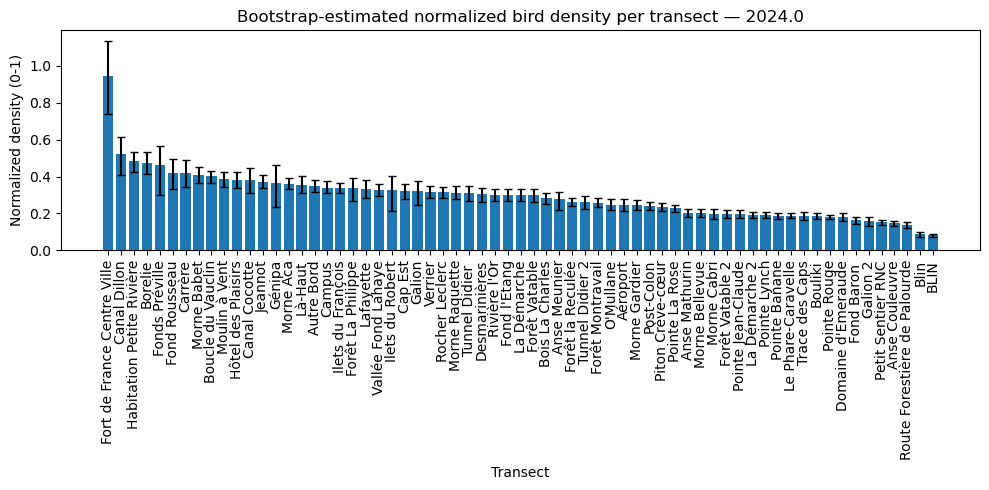

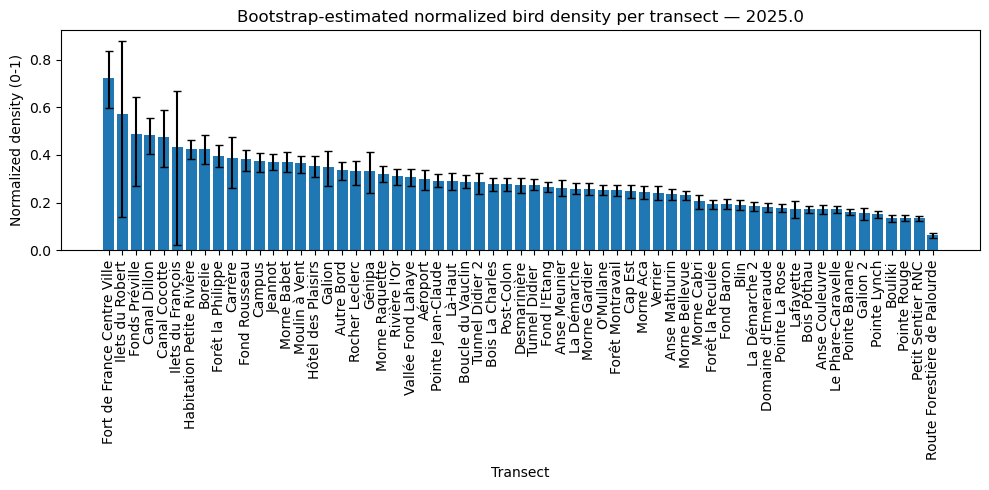

In [32]:

years = sorted(bootstrap_df["year"].unique())
# Plot normalized bird density per transect per year after Bootstrap 
for yr in years:
    subset = bootstrap_df[bootstrap_df["year"] == yr].sort_values("density_norm", ascending=False)
    
    plt.figure(figsize=(10, 5))
    plt.bar(
        subset["transect"],
        subset["density_norm"],
        yerr=[subset["density_norm"] - subset["ci_low_norm"], subset["ci_high_norm"] - subset["density_norm"]], # 95% Confidence Intervals
        capsize=3
    )
    plt.title(f"Bootstrap-estimated normalized bird density per transect — {yr}")
    plt.xlabel("Transect")
    plt.ylabel("Normalized density (0-1)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    if first_execution:
        plt.savefig(OUT_FIG / f"bootstrap_normalized_density_transects_{yr}.png")
    plt.show()

Top 5 transects with highest mean normalized density:
['Fort de France Centre Ville', 'Habitation Petite Rivière', 'Canal Dillon', 'Morne Babet', 'Moulin à Vent']


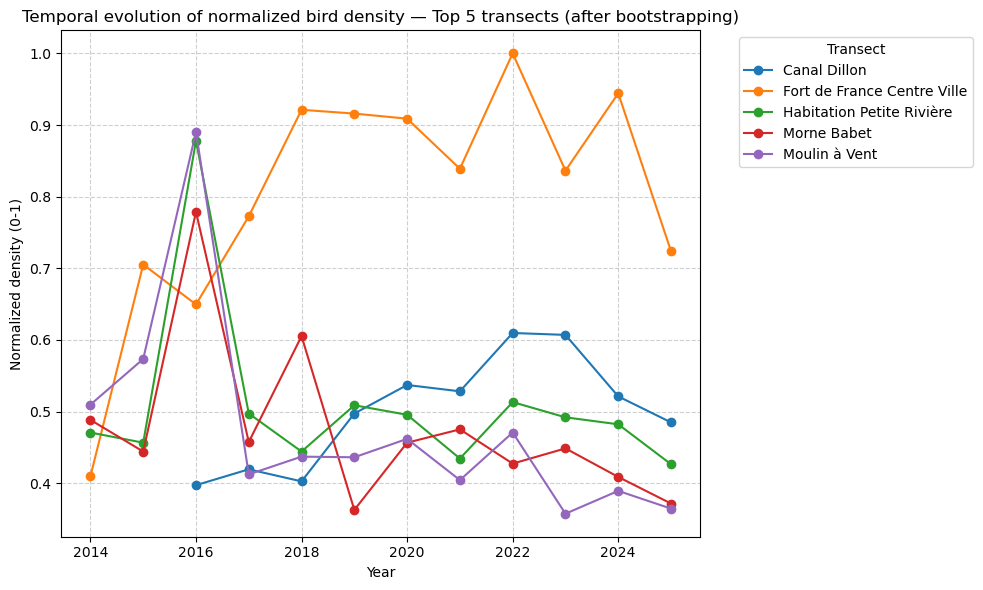

In [33]:
# Identify top 5 transects by mean normalized density across all years 
top_transects = (
    bootstrap_df.groupby("transect")["density_norm"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index
)

print("Top 5 transects with highest mean normalized density:")
print(top_transects.tolist())

# Filter data for only those transects 
top_df = bootstrap_df[bootstrap_df["transect"].isin(top_transects)]

# Plot temporal evolution for top 5 transects
plt.figure(figsize=(10, 6))
for transect, group in top_df.groupby("transect"):
    plt.plot(group["year"], group["density_norm"], marker="o", label=transect)

plt.title("Temporal evolution of normalized bird density — Top 5 transects (after bootstrapping)")
plt.xlabel("Year")
plt.ylabel("Normalized density (0-1)")
plt.legend(title="Transect", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "top5_transects_density_evolution.png")
plt.show()

### Detectability Study (auditory vs visual)

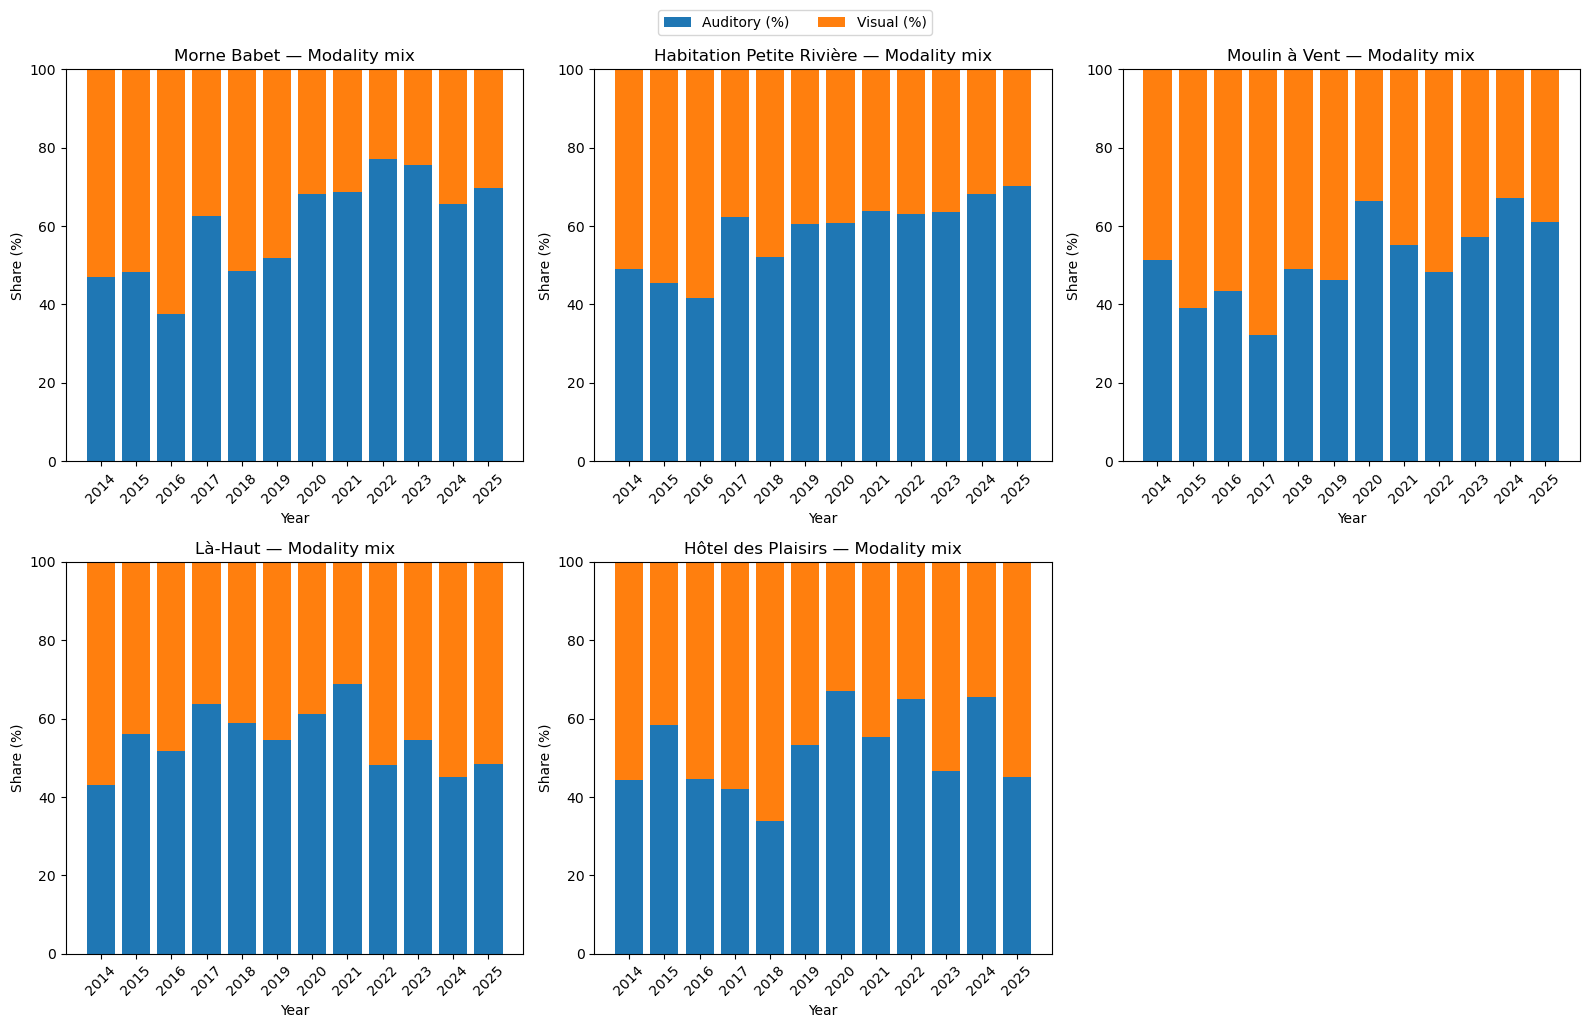

In [34]:
TOP_N = 5  # number of transects we analyze (ordered by most visited)

df_det = df_clean_nom_francais.copy()
df_det["date"] = pd.to_datetime(df_det["date"], errors="coerce")
df_det["year"] = pd.to_numeric(df_det["date"].dt.year, errors="coerce")
df_det["N° passage"] = pd.to_numeric(df_det["N° passage"], errors="coerce")

df_det = df_det.dropna(subset=["Nom transect", "year"])

ranking = df_det.groupby("Nom transect").size().sort_values(ascending=False)
top_transects = ranking.head(TOP_N).index.tolist()
df_det_top = df_det[df_det["Nom transect"].isin(top_transects)]

# We sum each total, grouped by year and transect
agg = (df_det_top.groupby(["Nom transect", "year"], dropna=False)
              .agg(A_sum=("TOT_A","sum"),
                   V_sum=("TOT_V_sV","sum"),
                   T_sum=("TOT_AV_sV","sum")) # We consider TOT_AV_sV as the total
              .reset_index())
total = agg["T_sum"]

agg["Auditory_pct"] = 100 * agg["A_sum"] / total
agg["Visual_pct"]   = 100 - agg["Auditory_pct"]

# Plot the histogram
n = len(top_transects)
ncols = min(3, n)
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), squeeze=False)

for i, tr in enumerate(top_transects):
    ax = axes[i // ncols, i % ncols]
    sub = agg[agg["Nom transect"] == tr].sort_values("year")
    years = sub["year"].astype(int).tolist()
    a = sub["Auditory_pct"].values
    v = sub["Visual_pct"].values

    ax.bar(years, a, label="Auditory (%)")
    ax.bar(years, v, bottom=a, label="Visual (%)")
    ax.set_title(f"{tr} — Modality mix")
    ax.set_xlabel("Year"); ax.set_ylabel("Share (%)")
    ax.set_ylim(0, 100)
    ax.set_xticks(years); ax.set_xticklabels(years, rotation=45)

# Hide empty axes
for j in range(i+1, nrows*ncols):
    axes[j // ncols, j % ncols].axis("off")

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.03))
fig.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "top_transects_modality_mix.png")
plt.show()


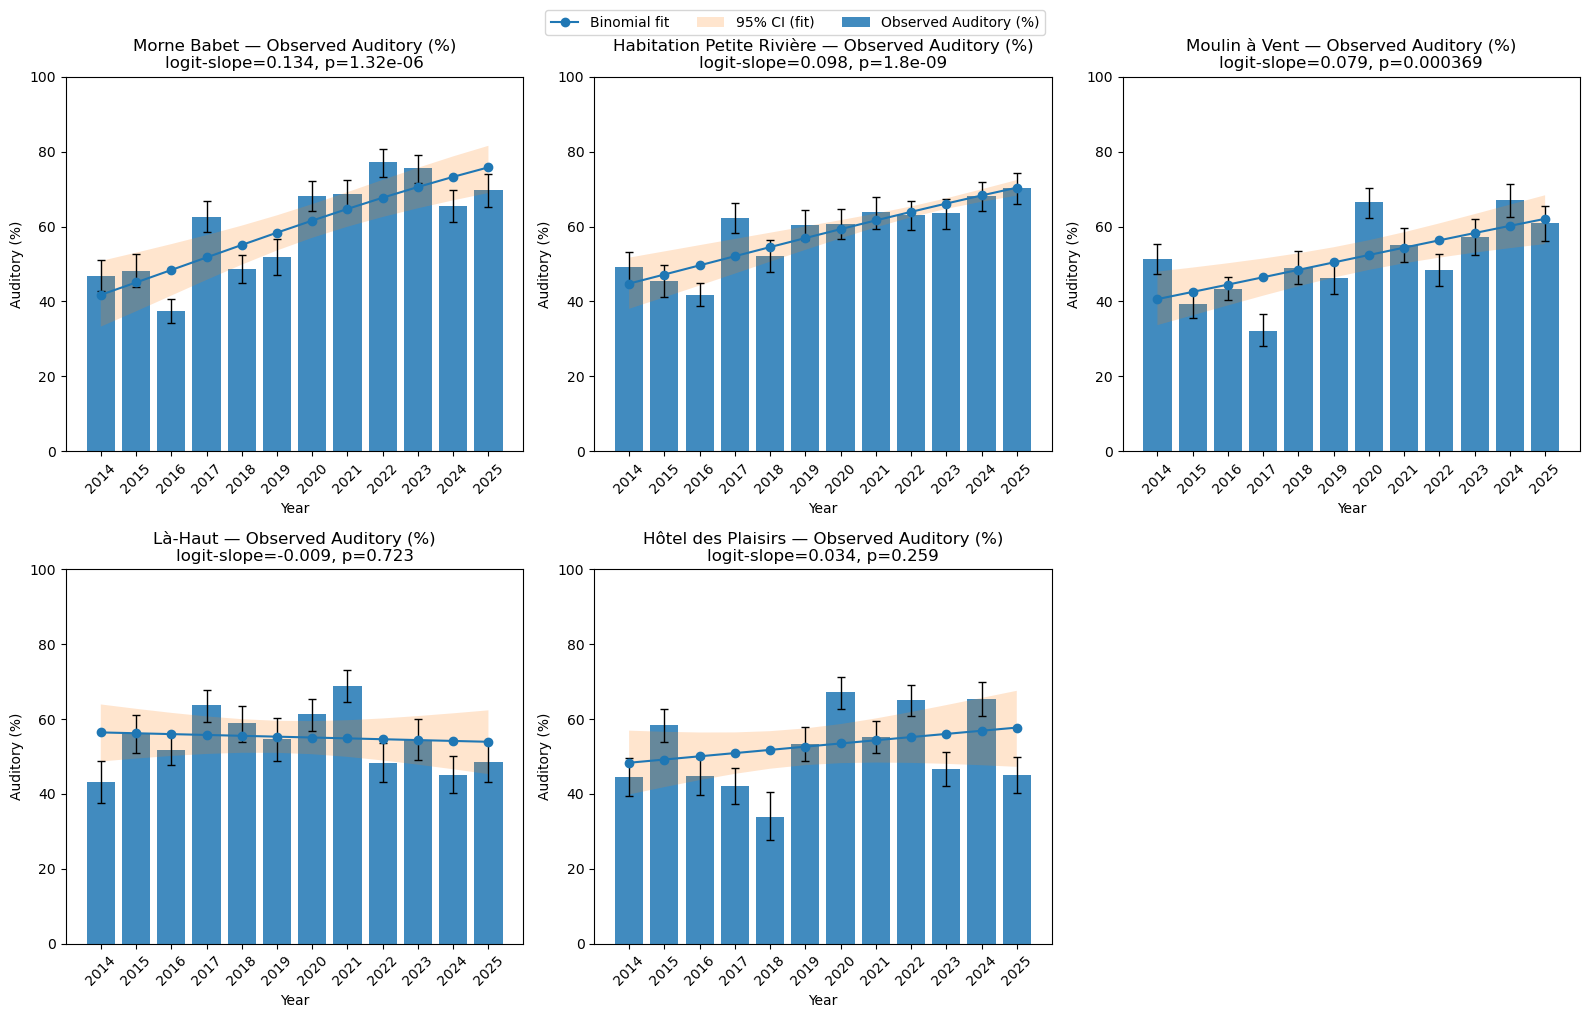

In [35]:
ci_low, ci_high = proportion_confint(
    count=agg["A_sum"].astype(float),
    nobs=agg["T_sum"].astype(float),
    alpha=0.05,
    method="wilson"
)
agg["Auditory_pct_low"]  = 100 * ci_low
agg["Auditory_pct_high"] = 100 * ci_high

# We plot the observed auditory (%) bars with Wilson CIs and GLM fit
transects = top_transects
n = len(transects)
ncols = min(3, n)
nrows = int(np.ceil(n / ncols)) if n else 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), squeeze=False)
axes = axes.flatten() if nrows*ncols > 1 else [axes]

for i, tr in enumerate(transects):
    ax = axes[i]
    sub = agg[agg["Nom transect"] == tr].sort_values("year").copy()
    years = sub["year"].astype(int).to_numpy()
    y_bar = sub["Auditory_pct"].to_numpy()

    # Bars: observed auditory %
    ax.bar(years, y_bar, label="Observed Auditory (%)", alpha=0.85)

    # Wilson error bars (only where defined)
    y_low  = sub["Auditory_pct_low"].to_numpy()
    y_high = sub["Auditory_pct_high"].to_numpy()
    yerr = np.vstack([y_bar - y_low, y_high - y_bar])
    ax.errorbar(years, y_bar, yerr=yerr, fmt="none", capsize=3, linewidth=1, ecolor="black")

    # GLM fit line + 95% CI band
    fit_df, slope, pval = fit_binom_glm(sub)
    ax.plot(fit_df["year"].astype(int), fit_df["pred"]*100, marker="o",
            linestyle="-", linewidth=1.5, label="Binomial fit")
    ax.fill_between(fit_df["year"].astype(int),
                    fit_df["ci_low"]*100, fit_df["ci_high"]*100,
                    alpha=0.20, label="95% CI (fit)")

    ax.set_title(f"{tr} — Observed Auditory (%)\nlogit-slope={slope:.3f}, p={pval:.3g}")
    ax.set_xlabel("Year"); ax.set_ylabel("Auditory (%)")
    ax.set_ylim(0, 100)
    ax.set_xticks(years); ax.set_xticklabels(years, rotation=45)

# Hide unused subplots 
for j in range(i + 1, nrows * ncols):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))

fig.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "top_transects_modality_glm_fit.png")
plt.show()

### Spacial Coverage Study

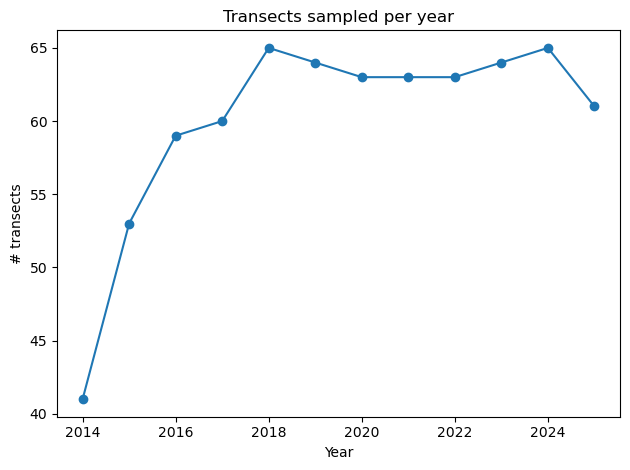

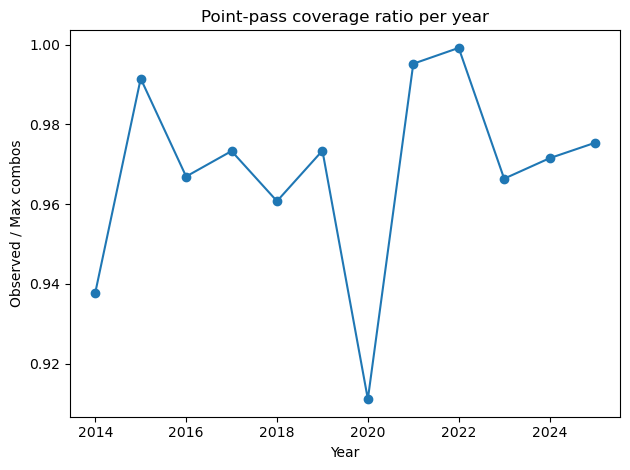

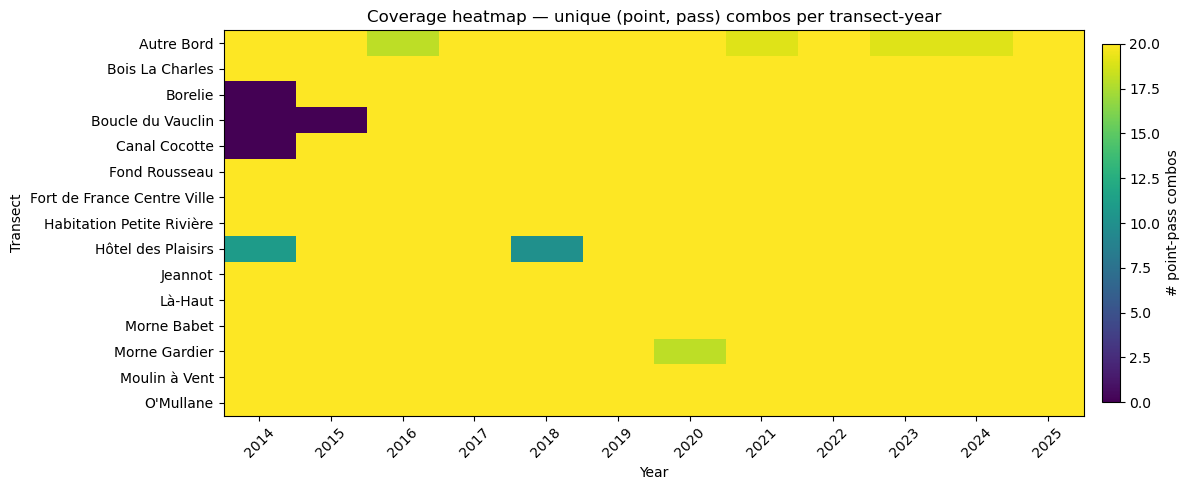

In [36]:
# We create a new table to analyse the spatial coverage
df_sp = df_clean_nom_francais.copy()

# Make sure date/year exist
df_sp["date"]  = pd.to_datetime(df_sp["date"], errors="coerce")
df_sp = df_sp.dropna(subset=["date"])
df_sp["year"] = df_sp["date"].dt.year

# We ensure all columns contain only numerical values
df_sp["point_n"] = pd.to_numeric(df_sp["N° point"], errors="coerce")
df_sp["N° passage"] = pd.to_numeric(df_sp["N° passage"], errors="coerce")

# We group the relevant indicators by year
yearly = (
    df_sp.groupby("year", dropna=True)
      .agg(transects=("Nom transect", "nunique"))
      .reset_index()
      .sort_values("year")
)

# We'll use this to calculate the coverage ratio per year
# To do that we take divide the unique (transect, point, pass) by the maximum number of (transects * points * passes) there can be (= transects * 10 * 2)
df_sp["combo"] = list(zip(df_sp["Nom transect"], df_sp["point_n"], df_sp["N° passage"]))

cov_y = (df_sp
           .groupby("year")
           .agg(obs_combos=("combo", "nunique")))
cov_y = cov_y.join(yearly.set_index("year")[["transects"]])
cov_y["max_combos"] = cov_y["transects"] * 10 * 2 
cov_y["combo_coverage"] = cov_y["obs_combos"] / cov_y["max_combos"]
yearly = yearly.merge(cov_y[["combo_coverage"]], left_on="year", right_index=True, how="left")

# Coverage heatmap data 
Top_transects = 15 # Number of top transects by visits that will appear in the heatmap

ded = (df_sp.dropna(subset=["point_n", "N° passage"])
         .drop_duplicates(subset=["Nom transect", "year", "point_n", "N° passage"]))
cov = (ded.groupby(["Nom transect", "year"])
           .size()
           .unstack(fill_value=0))

keep = df_sp["Nom transect"].value_counts().head(Top_transects).index
cov = cov.loc[cov.index.intersection(keep)]

# Transects sampled per year
plt.figure()
plt.plot(yearly["year"], yearly["transects"], marker="o")
plt.title("Transects sampled per year")
plt.xlabel("Year")
plt.ylabel("# transects")
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "transects_sampled_per_year.png")
plt.show()

# Coverage ratio per year
plt.figure()
plt.plot(yearly["year"], yearly["combo_coverage"], marker="o")
plt.title("Point-pass coverage ratio per year")
plt.xlabel("Year")
plt.ylabel("Observed / Max combos")
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "point_pass_coverage_ratio_per_year.png")
plt.show()

# Coverage heatmap (unique point-pass combos per transect-year)
plt.figure(figsize=(12, max(5, 0.3 * len(cov))))
im = plt.imshow(cov.values, aspect="auto")
plt.colorbar(im, fraction=0.02, pad=0.02, label="# point-pass combos")
plt.yticks(range(len(cov.index)), cov.index)
plt.xticks(range(len(cov.columns)), cov.columns, rotation=45)
plt.title("Coverage heatmap — unique (point, pass) combos per transect-year")
plt.xlabel("Year")
plt.ylabel("Transect")
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "coverage_heatmap_transect_year.png")
plt.show()

# Species-level Evolution 
---

### Abundance Study

In [37]:
# Compute total abundance per species
species_counts = (
    df.groupby("ESPECE")["TOT_AV_sV"]
    .sum()
    .sort_values(ascending=False)
)

top5_species = species_counts.head(5).index.tolist()
print("Top 5 most observed species:", top5_species)


Top 5 most observed species: ['Quiscale merle', 'Sucrier à ventre jaune', 'Elénie siffleuse', 'Tourterelle à queue carrée', 'Sporophile rougegorge']


In [38]:
# Top 5 abundance per species per year
top5_data = (
    df[df["ESPECE"].isin(top5_species)]
    .groupby(["year", "ESPECE"])["TOT_AV_sV"]
    .sum()
    .reset_index()
)
top5_data.head()

year                      ESPECE  TOT_AV_sV
0  2014.0            Elénie siffleuse        669
1  2014.0              Quiscale merle       1793
2  2014.0       Sporophile rougegorge        812
3  2014.0      Sucrier à ventre jaune       1603
4  2014.0  Tourterelle à queue carrée        861

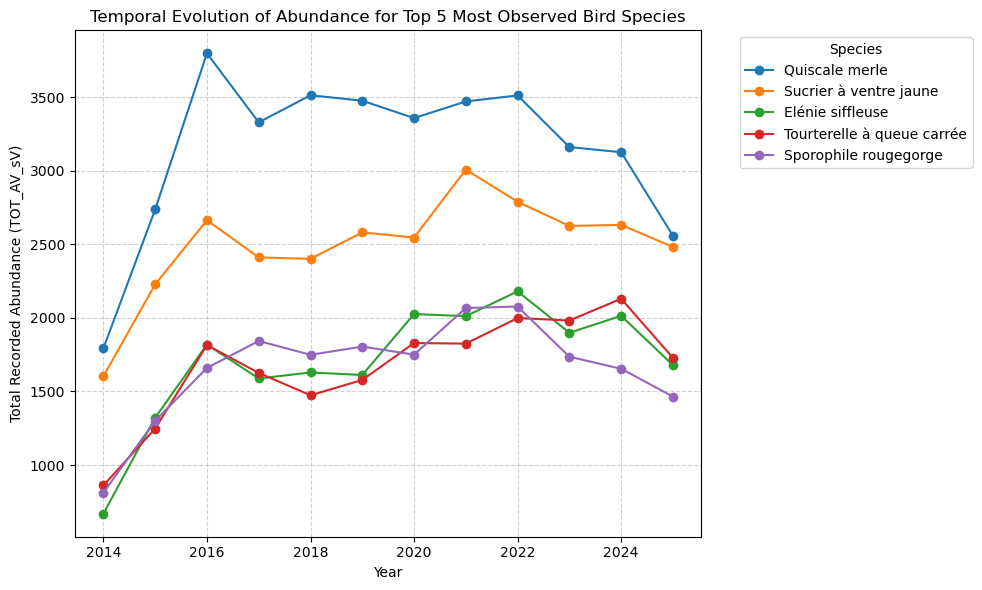

In [39]:
# Plot Top 5 bird species abundance evolution
plt.figure(figsize=(10, 6))

for species in top5_species:
    sub = top5_data[top5_data["ESPECE"] == species]
    plt.plot(sub["year"], sub["TOT_AV_sV"], marker="o", label=species)

plt.title("Temporal Evolution of Abundance for Top 5 Most Observed Bird Species")
plt.xlabel("Year")
plt.ylabel("Total Recorded Abundance (TOT_AV_sV)")
plt.legend(title="Species", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "top5_species_abundance_evolution.png")
plt.show()


#### Normalization to compare trends

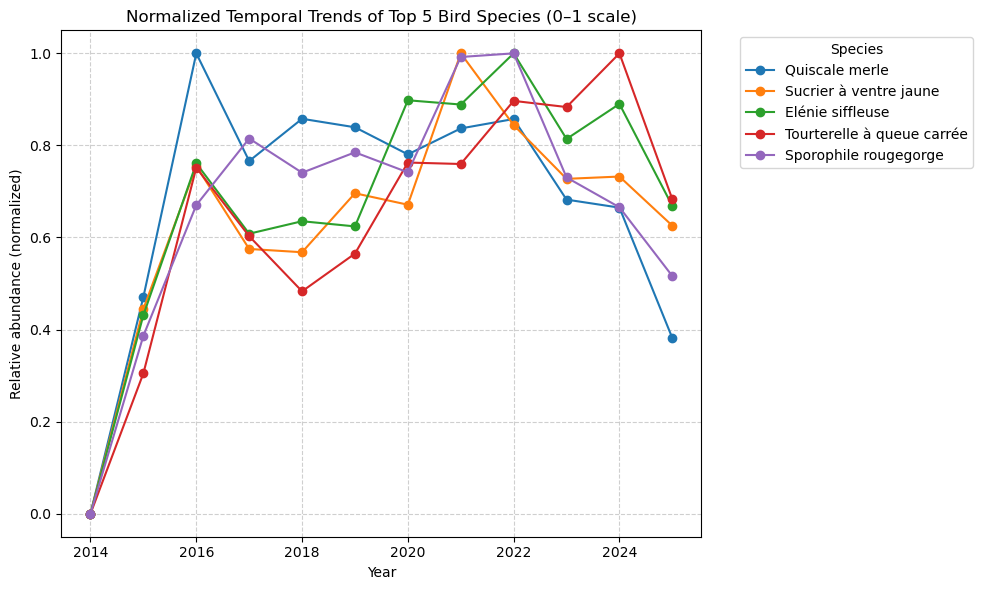

In [40]:
top5_data_norm = top5_data.copy()
top5_data_norm["scaled"] = top5_data_norm.groupby("ESPECE")["TOT_AV_sV"].transform(
    lambda s: (s - s.min()) / (s.max() - s.min() + 1e-9)
)

# Plot Top 5 bird species normalized abundance evolution
plt.figure(figsize=(10, 6))
for species in top5_species:
    sub = top5_data_norm[top5_data_norm["ESPECE"] == species]
    plt.plot(sub["year"], sub["scaled"], marker="o", label=species)

plt.title("Normalized Temporal Trends of Top 5 Bird Species (0–1 scale)")
plt.xlabel("Year")
plt.ylabel("Relative abundance (normalized)")
plt.legend(title="Species", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "top5_species_normalized_abundance_evolution.png")
plt.show()


#### Bootstrap + CIs

In [41]:
bootstrap_results = []
# Apply boostrat mean function to the 5 studied bird species 
for species in top5_species:
    sp = df[df["ESPECE"] == species]
    
    for year, group in sp.groupby("year"):
        counts = group["TOT_AV_sV"].values
        
        mean, ci_low, ci_high = bootstrap_ci(counts,func=np.mean, B=1000, alpha=0.05)
        
        bootstrap_results.append({
            "species": species,
            "year": year,
            "mean_abundance": mean,
            "ci_low": ci_low,
            "ci_high": ci_high
        })

bootstrap_df_species = pd.DataFrame(bootstrap_results).sort_values(["species","year"])
bootstrap_df_species.head()


species    year  mean_abundance    ci_low   ci_high
24  Elénie siffleuse  2014.0        1.668329  1.566022  1.780549
25  Elénie siffleuse  2015.0        1.992459  1.901961  2.081448
26  Elénie siffleuse  2016.0        2.086009  1.934633  2.206422
27  Elénie siffleuse  2017.0        2.092227  1.977602  2.201614
28  Elénie siffleuse  2018.0        1.932384  1.861180  2.002402

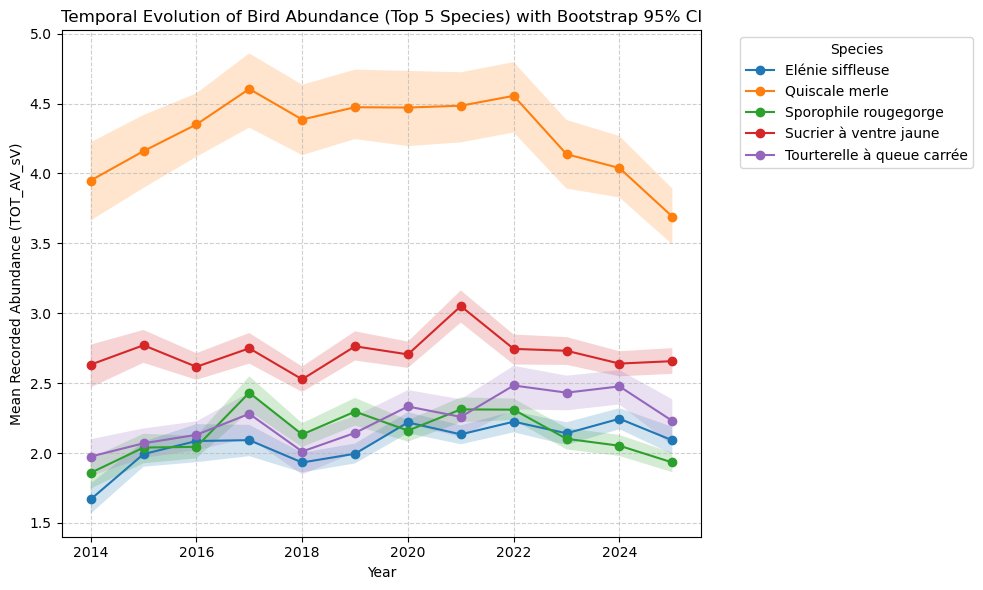

In [42]:
# Plot the temporal evolution of bird abundance after Bootstrap
plt.figure(figsize=(10, 6))

for species, group in bootstrap_df_species.groupby("species"):
    plt.plot(group["year"], group["mean_abundance"], marker="o", label=species)
    plt.fill_between(group["year"], group["ci_low"], group["ci_high"], alpha=0.2)

plt.title("Temporal Evolution of Bird Abundance (Top 5 Species) with Bootstrap 95% CI")
plt.xlabel("Year")
plt.ylabel("Mean Recorded Abundance (TOT_AV_sV)")
plt.legend(title="Species", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
if first_execution:
    plt.savefig(OUT_FIG / "top5_species_abundance_evolution_bootstrap.png")
plt.show()


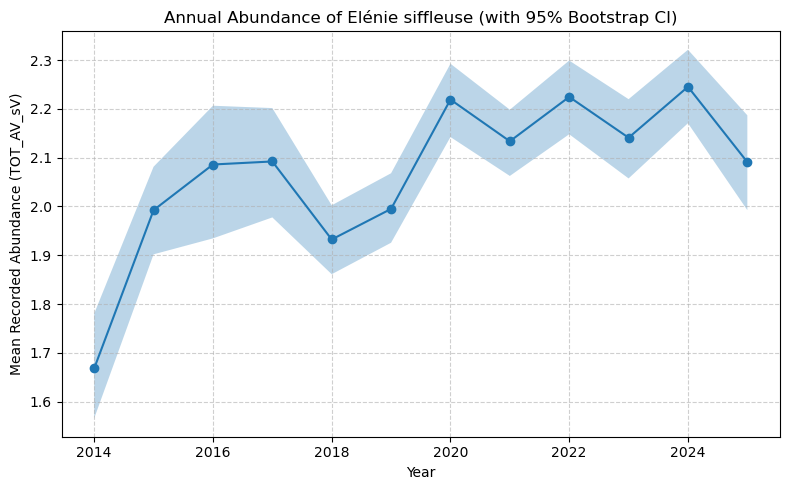

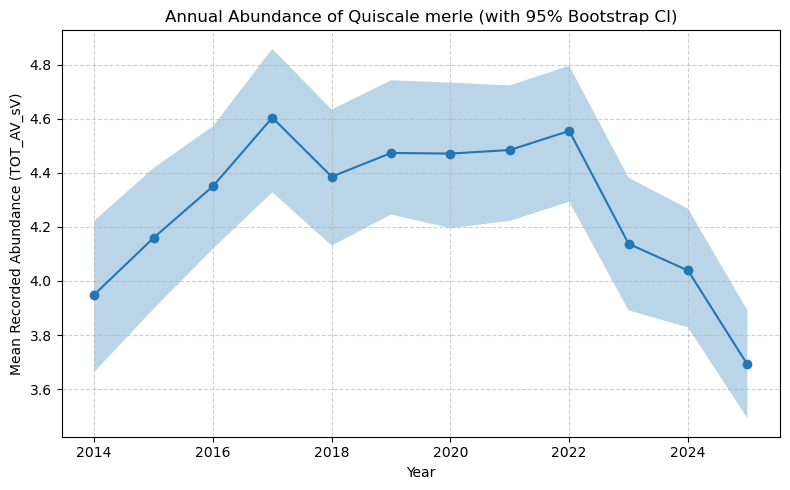

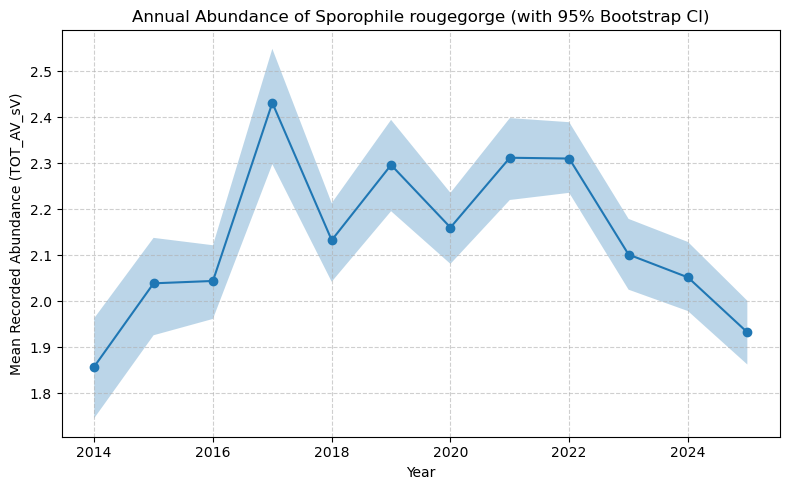

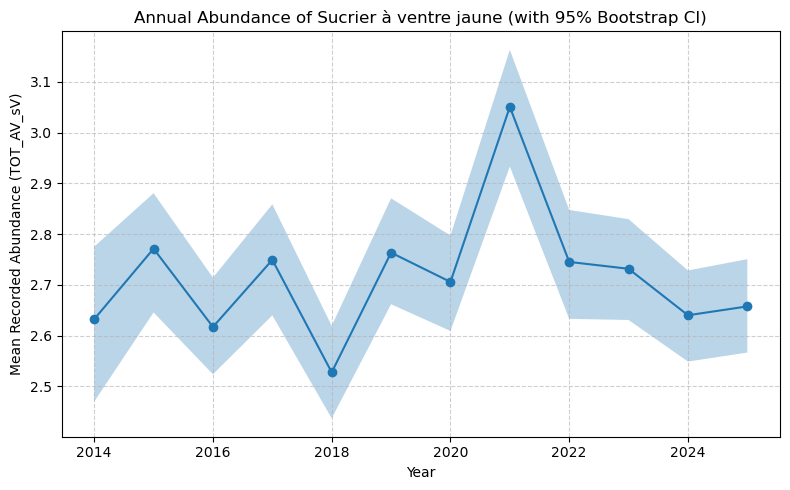

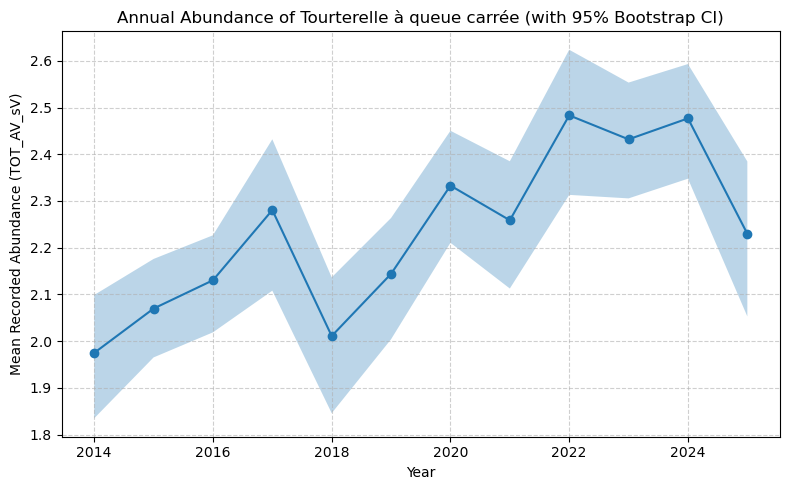

In [43]:
# Plot the idividual temporal evolution of bird abundance
for species, group in bootstrap_df_species.groupby("species"):
    plt.figure(figsize=(8,5))
    plt.plot(group["year"], group["mean_abundance"], marker="o")
    plt.fill_between(group["year"], group["ci_low"], group["ci_high"], alpha=0.3)
    plt.title(f"Annual Abundance of {species} (with 95% Bootstrap CI)")
    plt.xlabel("Year")
    plt.ylabel("Mean Recorded Abundance (TOT_AV_sV)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    if first_execution:
        plt.savefig(OUT_FIG / f"{species.replace(' ','_')}_abundance_evolution_bootstrap.png")
    plt.show()


## Trend Significance per Species

In [44]:
trend_results = []

for species, group in bootstrap_df_species.groupby("species"):
    
    # Sort by year to ensure correct alignment
    group = group.sort_values("year")
    
    # Linear regression test
    X = sm.add_constant(group["year"])   # predictor: year
    y = group["mean_abundance"]         # response: bootstrapped mean abundance
    model = sm.OLS(y, X).fit()
    
    slope = model.params["year"]
    p_slope = model.pvalues["year"]
    r2 = model.rsquared
    
   
    trend_results.append({
        "species": species,
        "slope (OLS)": slope,
        "p-value (OLS slope)": p_slope,
        "R² (trend fit)": r2
    })

trend_results_df = pd.DataFrame(trend_results)
trend_results_df

species  slope (OLS)  p-value (OLS slope)  \
0            Elénie siffleuse     0.030759             0.011863   
1              Quiscale merle    -0.018780             0.448744   
2       Sporophile rougegorge     0.003967             0.795352   
3      Sucrier à ventre jaune     0.004862             0.672132   
4  Tourterelle à queue carrée     0.036800             0.004150   

   R² (trend fit)  
0        0.485021  
1        0.058521  
2        0.007046  
3        0.018651  
4        0.577075

### Trend Line + Bootstrap CI + Observed Points (per species)

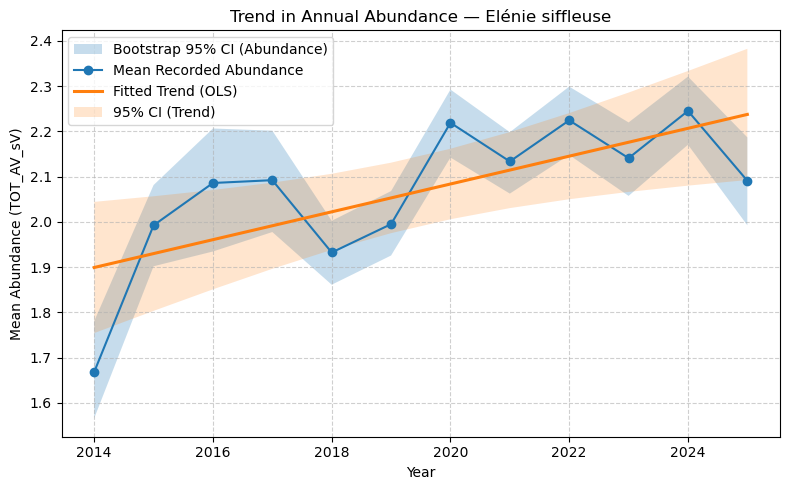

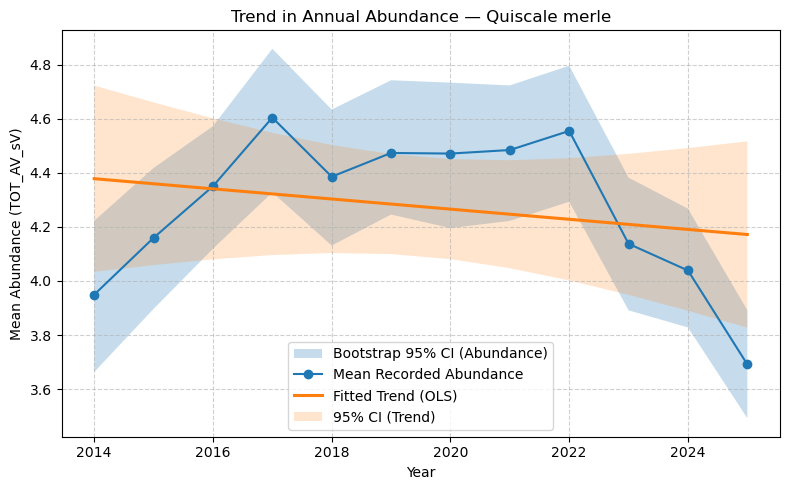

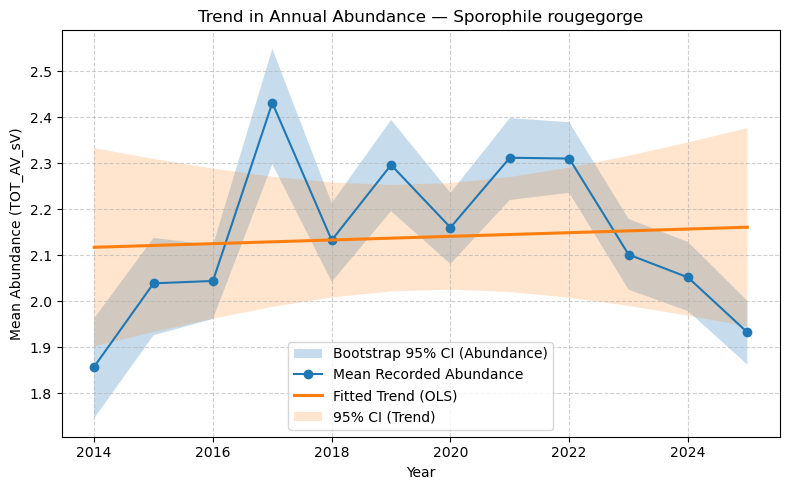

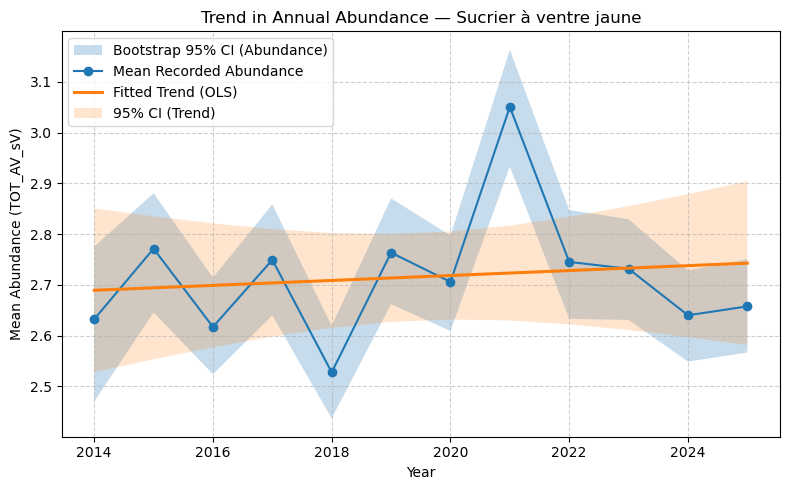

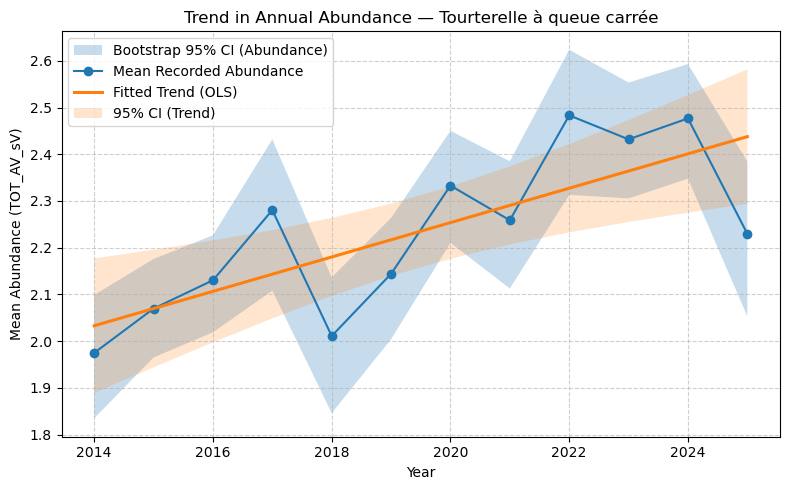

In [45]:
for species, group in bootstrap_df_species.groupby("species"):
    
    group = group.sort_values("year")  # ensure correct order
    years = group["year"].values
    y = group["mean_abundance"].values
    
    # Fit regression for the species
    X = sm.add_constant(years)
    model = sm.OLS(y, X).fit()
    
    # Predictions + Confidence Interval for trend line
    pred = model.get_prediction(X).summary_frame(alpha=0.05)
    y_fit = pred["mean"]
    y_low = pred["mean_ci_lower"]
    y_high = pred["mean_ci_upper"]
    
    # Plot
    plt.figure(figsize=(8,5))
    
    # Bootstrap Confidence Intervals 95%
    plt.fill_between(years, group["ci_low"], group["ci_high"], alpha=0.25, label="Bootstrap 95% CI (Abundance)")
    
    # Observed points
    plt.plot(years, y, marker="o", linewidth=1.5, label="Mean Recorded Abundance")
    
    # Linear regression trend
    plt.plot(years, y_fit, linewidth=2.2, label="Fitted Trend (OLS)")
    
    # Confidence band for trend
    plt.fill_between(years, y_low, y_high, alpha=0.2, label="95% CI (Trend)")
    
    plt.title(f"Trend in Annual Abundance — {species}")
    plt.xlabel("Year")
    plt.ylabel("Mean Abundance (TOT_AV_sV)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(loc="best")
    plt.tight_layout()
    if first_execution:
        plt.savefig(OUT_FIG / f"{species.replace(' ','_')}_abundance_trend_analysis.png")
    plt.show()


### Per-transect detection rate trends

In [46]:
# Define a canonical point-visit (denominator for detection rates)
visit_cols = ["Nom transect", "N° point", "date", "N° passage"]
df["visit_id"] = df[visit_cols].astype(str).agg("|".join, axis=1)

# Total visits per transect-year (denominator)
visits_tr_year = (
    df.drop_duplicates(["visit_id"])
      .groupby(["Nom transect", "year"])
      .size()
      .rename("N_visits_tr_year")
      .reset_index()
)


In [47]:
# Mark detections for each species-row
df["detected"] = (df["TOT_AV_sV"] > 0).astype(int)

# Detections per species–transect–year (K_detects)
det_counts = (
    df[df["detected"] == 1]
      .drop_duplicates(["visit_id", "ESPECE"])  # one detection per visit per species
      .groupby(["ESPECE", "Nom transect", "year"])
      .size()
      .rename("K_detects")
      .reset_index()
)

# Evaluate only the combos we care about: (top-5 species) × (transect, year)
comb = (
    df[df["ESPECE"].isin(top5_species)]
      .drop_duplicates(["ESPECE", "Nom transect", "year"])
      [["ESPECE", "Nom transect", "year"]]
)

# Bring in denominators then detection counts
det_tr_yr = (
    comb
    .merge(visits_tr_year, on=["Nom transect", "year"], how="left")
    .merge(det_counts, on=["ESPECE", "Nom transect", "year"], how="left")
)

# Fill and compute detection rate
det_tr_yr["N_visits_tr_year"] = det_tr_yr["N_visits_tr_year"].fillna(0).astype(int)
det_tr_yr["K_detects"] = det_tr_yr["K_detects"].fillna(0).astype(int)
det_tr_yr["det_rate"] = np.where(
    det_tr_yr["N_visits_tr_year"] > 0,
    det_tr_yr["K_detects"] / det_tr_yr["N_visits_tr_year"],
    np.nan
)

det_tr_yr.head(10)


ESPECE                 Nom transect    year  \
0      Sucrier à ventre jaune                 Fond l'Etang  2014.0   
1            Elénie siffleuse                 Fond l'Etang  2014.0   
2       Sporophile rougegorge                 Fond l'Etang  2014.0   
3              Quiscale merle                 Fond l'Etang  2014.0   
4  Tourterelle à queue carrée                 Fond l'Etang  2014.0   
5              Quiscale merle  Fort de France Centre Ville  2014.0   
6       Sporophile rougegorge  Fort de France Centre Ville  2014.0   
7  Tourterelle à queue carrée  Fort de France Centre Ville  2014.0   
8      Sucrier à ventre jaune  Fort de France Centre Ville  2014.0   
9            Elénie siffleuse  Fort de France Centre Ville  2014.0   

   N_visits_tr_year  K_detects  det_rate  
0                20         14      0.70  
1                20         15      0.75  
2                20         12      0.60  
3                20          6      0.30  
4                20          5      0.25  
5                20         15      0.75  
6                20         13      0.65  
7                20         18      0.90  
8                20         12      0.60  
9                20          2      0.10

In [48]:

for sp in top5_species:
    d_sp = det_tr_yr[det_tr_yr["ESPECE"] == sp]
    top_tr = (d_sp.groupby("Nom transect")["N_visits_tr_year"].sum()
                    .sort_values(ascending=False).head(6).index)
    print(f"\n=== {sp} ===")
    for tr in top_tr:
        d_tr = d_sp[d_sp["Nom transect"] == tr].sort_values("year")
        res = fit_logistic_trend_per_transect_1(d_tr)
        if res is None:
            print(f"- {tr}: not enough data")
        else:
            slope = res.params.get("year", np.nan)
            pval = res.pvalues.get("year", np.nan)
            print(f"- {tr}: slope={slope:.4f}, p={pval:.3f}")



=== Quiscale merle ===
- Petit Sentier RNC: slope=-0.0059, p=0.888
- Fort de France Centre Ville: slope=-0.0290, p=0.542
- Tunnel Didier 2: slope=0.0029, p=0.941
- Habitation Petite Rivière: slope=-0.1644, p=0.020
- O'Mullane: slope=-0.0775, p=0.074
- Fond Rousseau: slope=0.0342, p=0.506

=== Sucrier à ventre jaune ===
- Petit Sentier RNC: slope=-0.0410, p=0.301
- Tunnel Didier 2: slope=0.0194, p=0.779
- Pointe Lynch: slope=0.1390, p=0.001
- Fort de France Centre Ville: slope=0.0115, p=0.781
- Habitation Petite Rivière: slope=-0.0239, p=0.773
- Fond Rousseau: slope=0.0901, p=0.083

=== Elénie siffleuse ===
- Tunnel Didier 2: slope=0.1104, p=0.008
- Pointe Lynch: slope=0.1299, p=0.007
- Habitation Petite Rivière: slope=0.1000, p=0.018
- Galion: slope=-0.1401, p=0.001
- Morne Babet: slope=0.0790, p=0.041
- La Démarche: slope=0.3111, p=0.000

=== Tourterelle à queue carrée ===
- Petit Sentier RNC: slope=-0.0363, p=0.364
- Fort de France Centre Ville: slope=-0.0232, p=0.737
- Pointe Lynch

In [49]:
# Add CI columns to det_tr_yr
ci = det_tr_yr.apply(lambda r: wilson_ci(r["K_detects"], r["N_visits_tr_year"]), axis=1)
det_tr_yr["det_low"], det_tr_yr["det_high"] = zip(*ci)


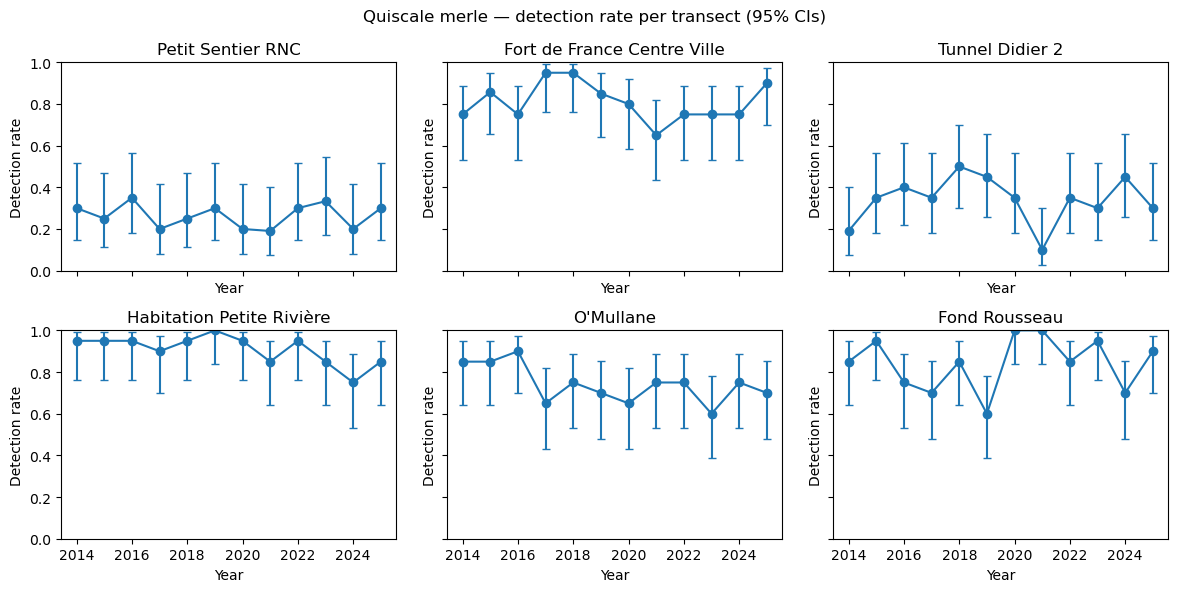

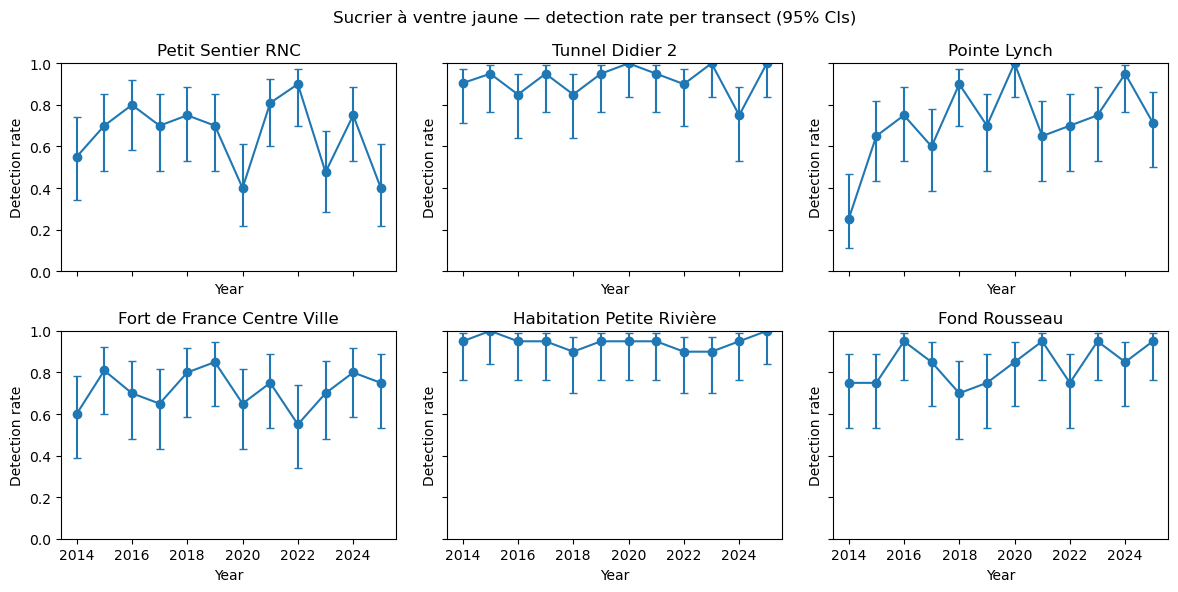

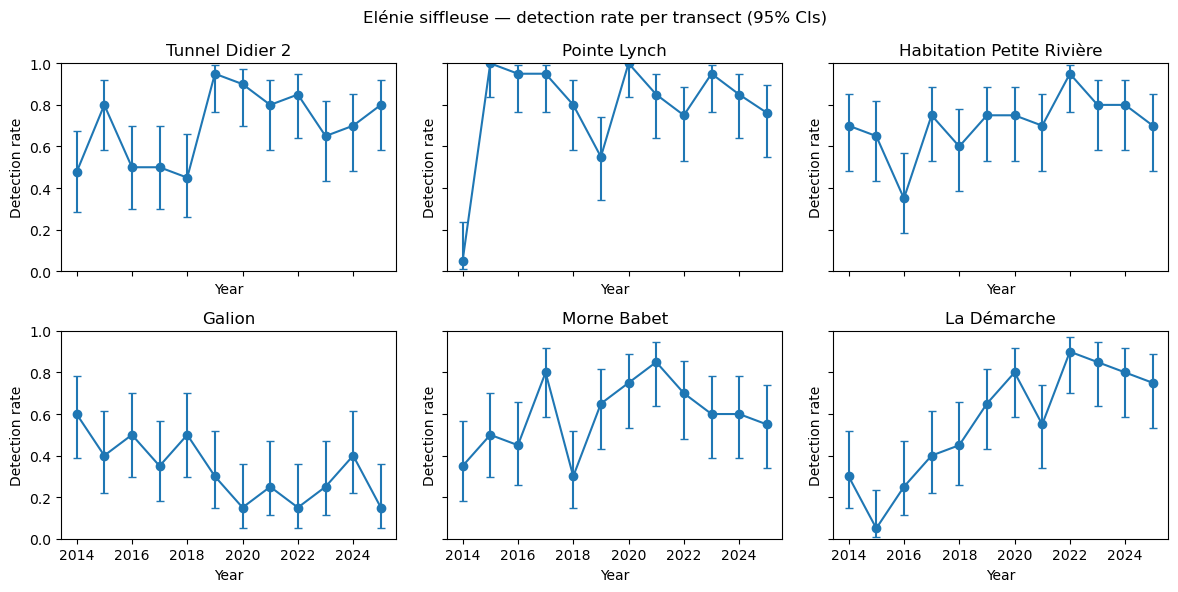

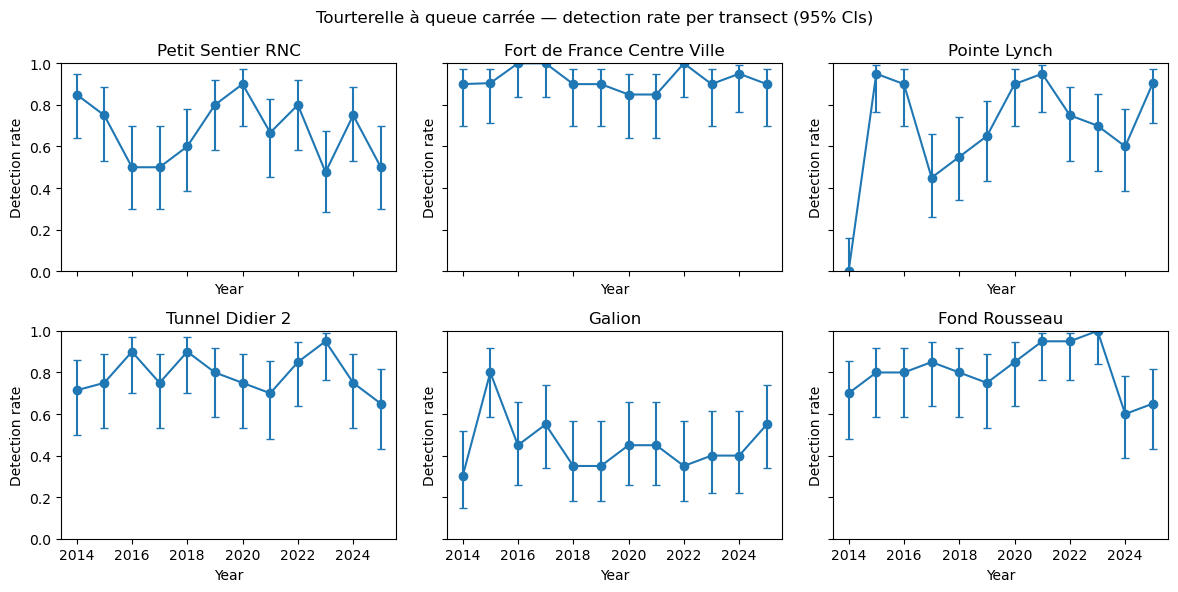

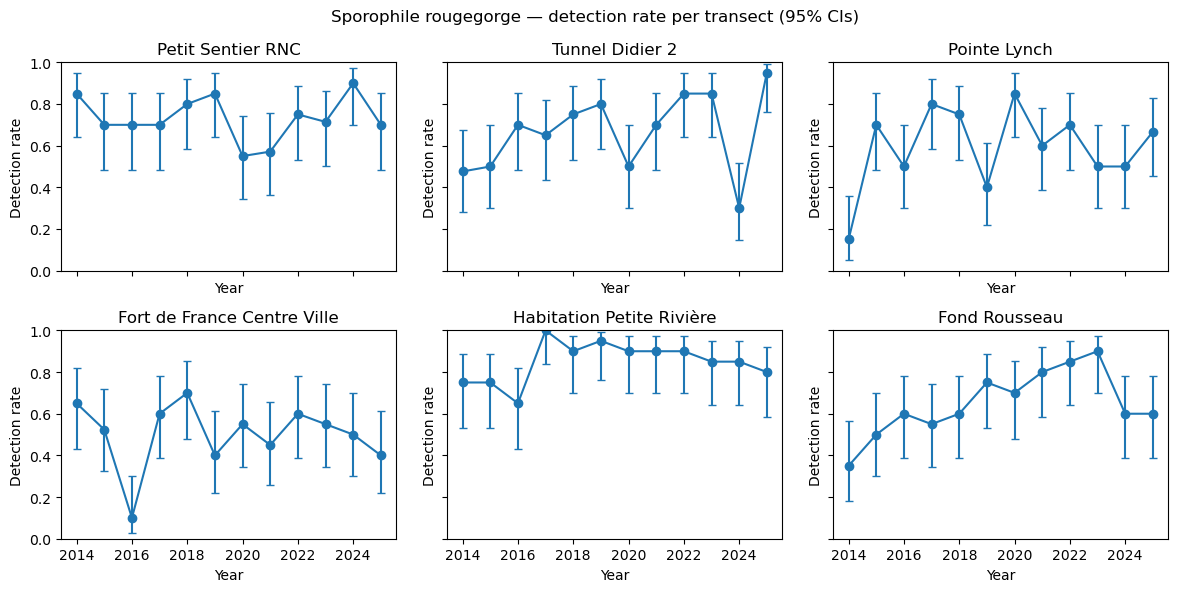

In [50]:
for sp in top5_species:
    plot_transect_panels_with_ci(det_tr_yr, sp, n_tr=6, first_execution=first_execution, OUT_FIG=OUT_FIG)

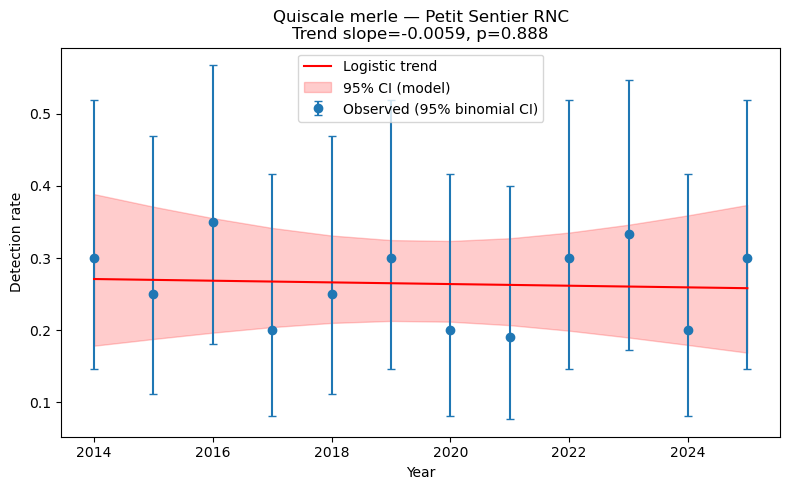

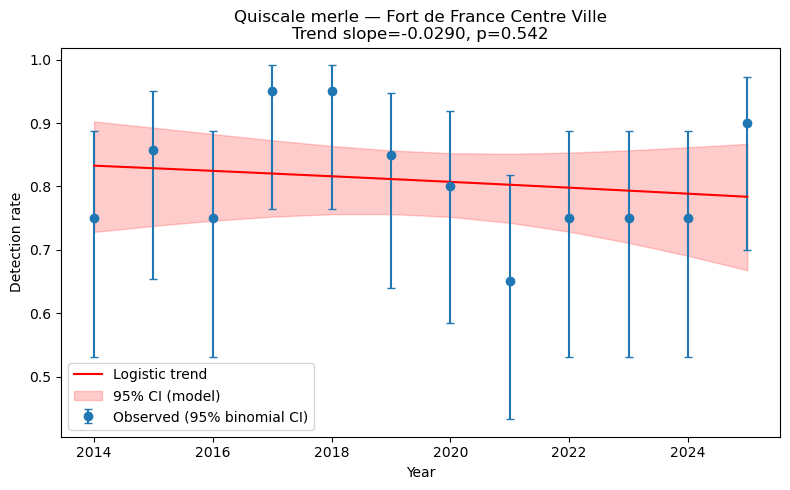

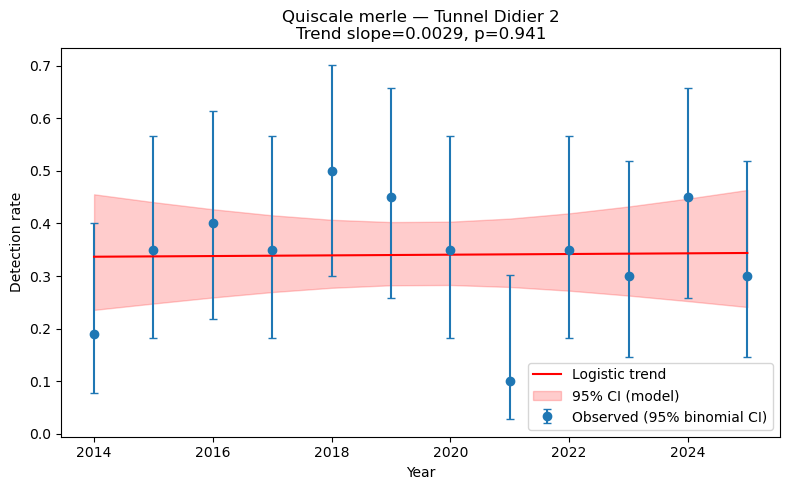

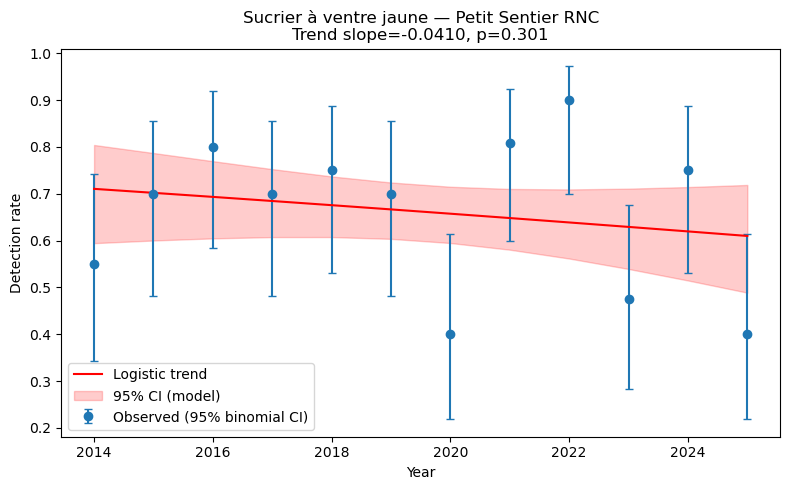

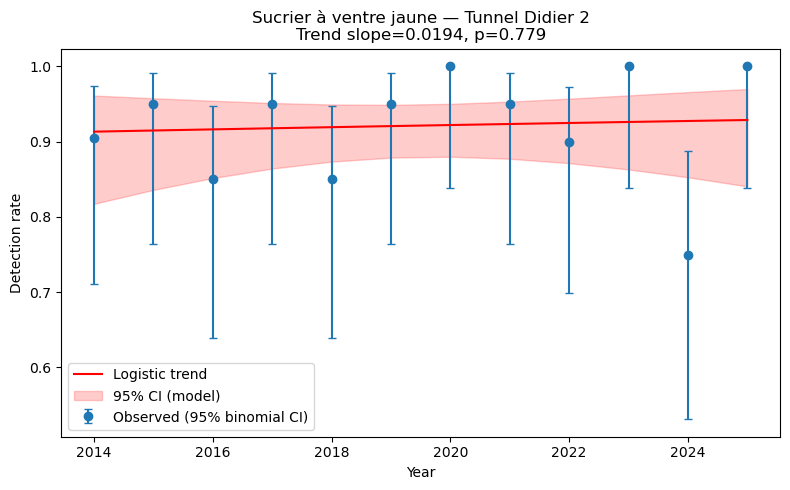

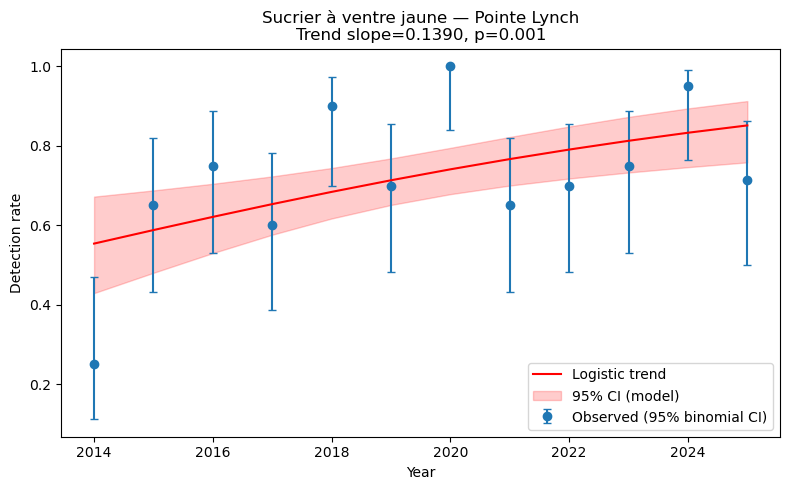

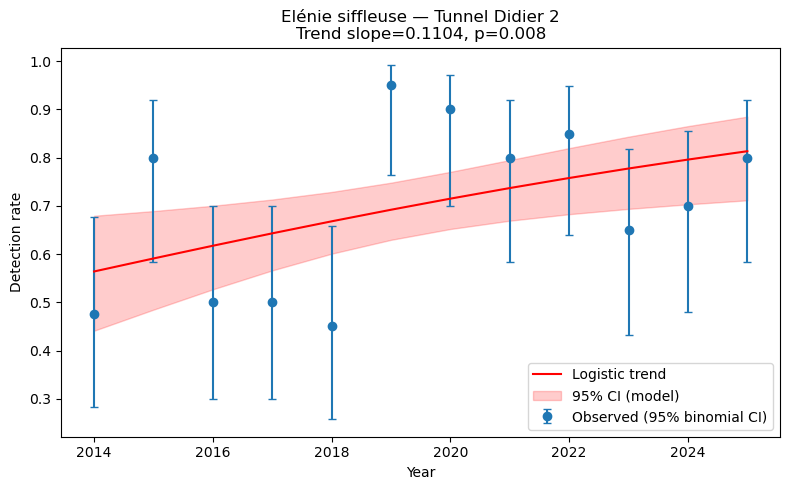

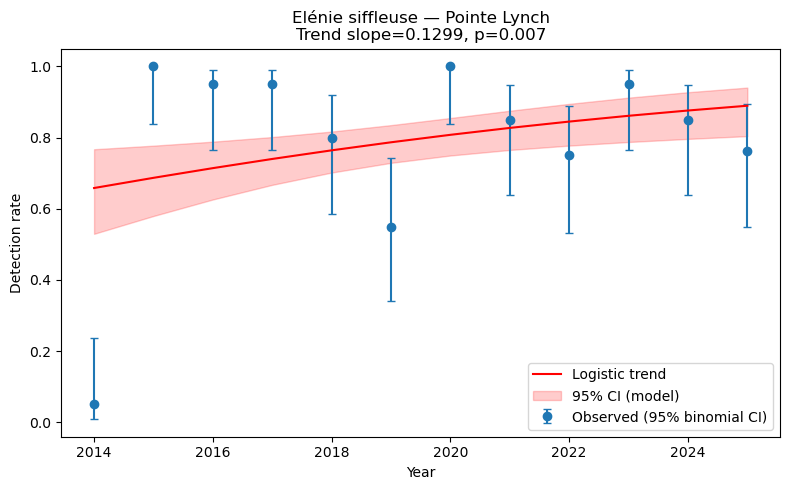

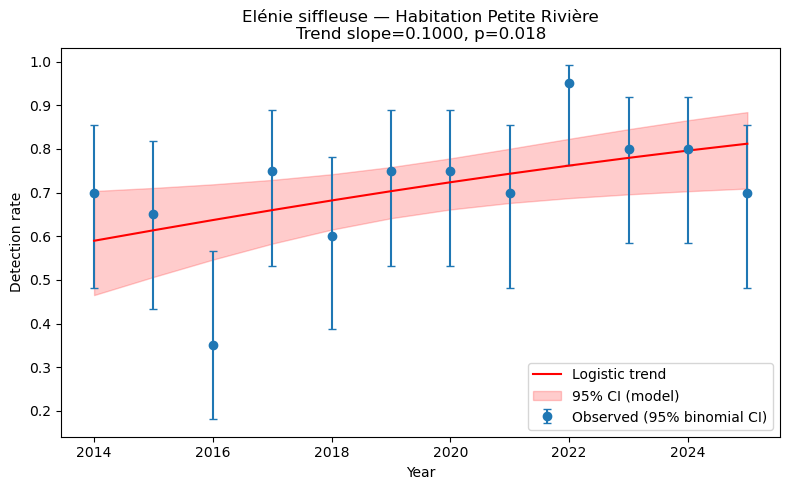

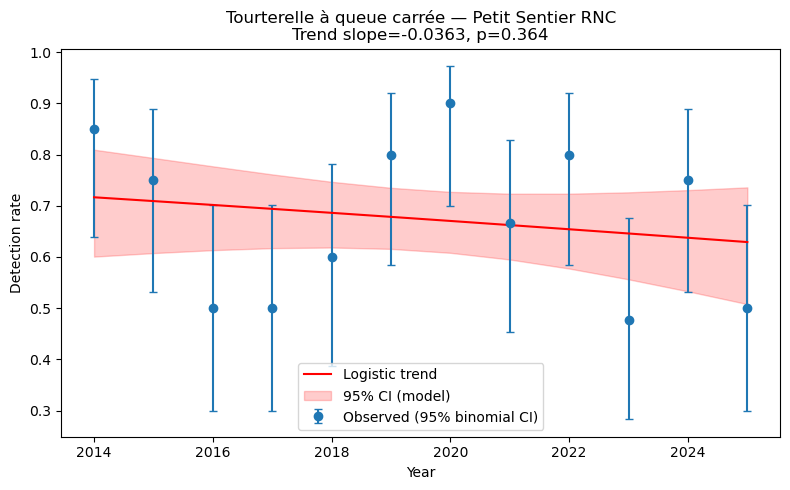

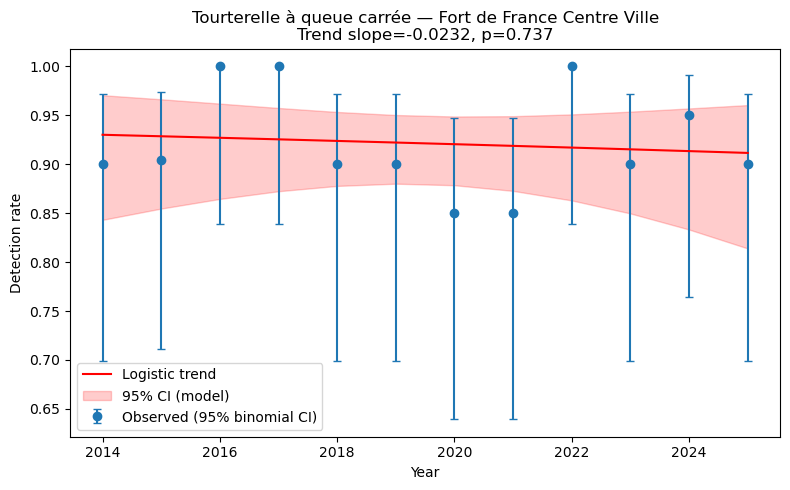

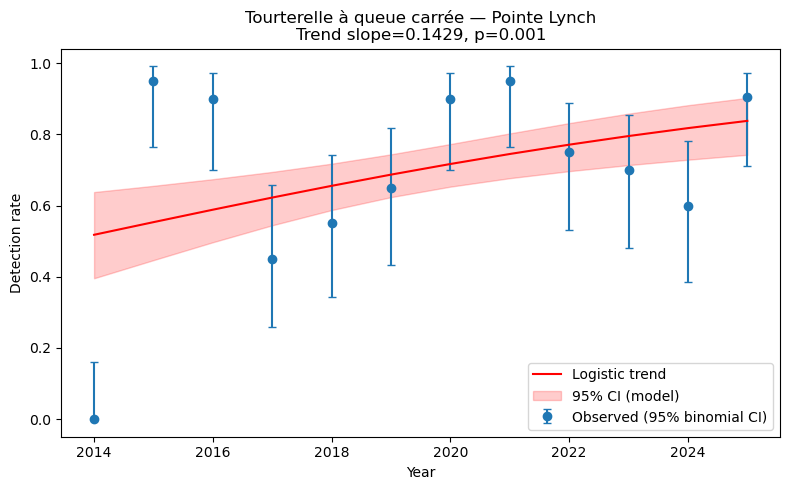

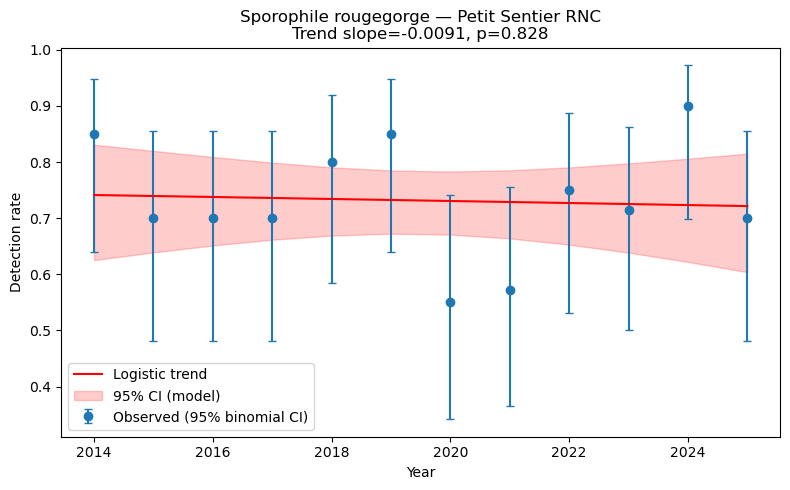

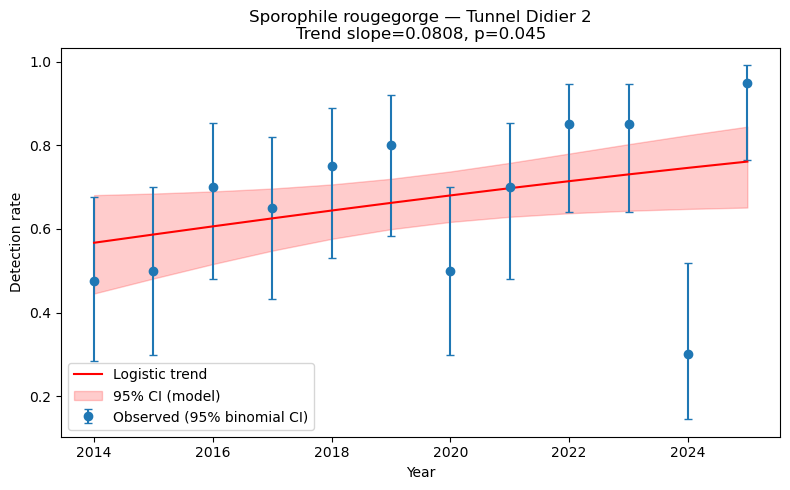

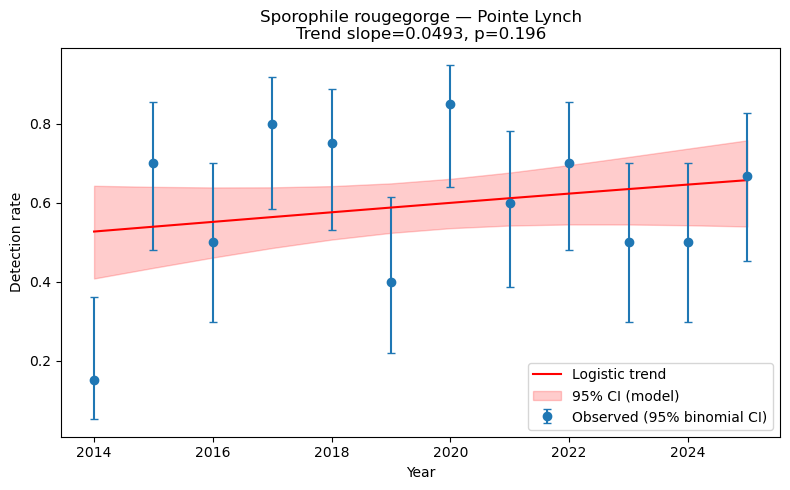

In [51]:
# Example: plot a couple of transects per species
for sp in top5_species:
    d_sp = det_tr_yr[det_tr_yr["ESPECE"] == sp]
    top_tr = (d_sp.groupby("Nom transect")["N_visits_tr_year"].sum()
                    .sort_values(ascending=False).head(3).index)
    for tr in top_tr:
        plot_transect_with_model(det_tr_yr, sp, tr, first_execution=first_execution, OUT_FIG=OUT_FIG)
